In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from env import user, password, host
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import levene, ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import math
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# 1. PLAN
 #### a. acquire
 #### b. prep
 #### c. explore data
 #### d. make hypothesis
 #### e. identify features that have large numbers of diabetics associated with them
 #### f. determine if feature and outcome are significantly associated using Chi Squared
 #### g. make sure other features are not impacting selected feature variable using Chi Squared
 #### h. fit best model to predict outcome using selected features
 #### i. takeaways:
 #####   - evaluate outcome on individual features
 #####   - evaluate outcome on combination of fetaures
 #####   - evaluate model's efficacy
 #### j. give recommendations

# Initital Thoughts
#### The data frame is a collection of medical measurements that directly influence whether or not a person has diabetes.  Domain background knowledge helps with this df.  The more pregnancies, the higher probability you will have gestastional diabetes that may resolve after pregnancy.  Glucose measurements below 99 may indicate that you are not diabetic, but prediabetic.  If you have diabetes, it strains your kidneys, which makes your blood pressure rise.  A physical symptom of diabetics is thickening of the skin around the neck and it darkens it, too. The insulin measurement indicates how much insulin is in your blood test and higher the number the higher the chance of diabetes.  The same with BMI, high is bad,  The Diabetes Pedigree Function is a function which scores likelihood of diabetes based on family history, so higher numbers indicate that you may more predisposed to diabetes.

### Exploring this df will help us  to see which of the measurement has a high (or higher) correlation to the outcome.

# Acquire the data

In [3]:
#read in the csv
diabetes_df = pd.read_csv('diabetes.csv')

## Summarize the data

In [4]:
#get a quick look at the df
diabetes_df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [5]:
# looks at math stats
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
#see shape (rows and columns), column names, non null counts and data types
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
# drop any Nan's
diabetes_df = diabetes_df.dropna()

In [8]:
# drop duplicates
diabetes_df = diabetes_df.drop_duplicates()

In [9]:
# examining missing values
print("Missing values distribution: ")
print(diabetes_df.isnull().mean())
print("")

Missing values distribution: 
Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64



In [10]:
# rename lower case and insert _ for separation of words in column names for better readability and easy manipulations of columns
diabetes_df=diabetes_df.rename(columns={'Pregnancies': 'pregnancies',
                          'Glucose':'glucose',
                          'BloodPressure':'blood_pressure',
                          'SkinThickness':'skin_thickness',
                          'Insulin':'insulin',
                          'BMI':'bmi',
                          'DiabetesPedigreeFunction': 'diabetes_pedigree_function',
                          'Age':'age',
                          'Outcome': 'outcome',
                          })

In [11]:
# Count number of zeros in all columns of Dataframe
for column_name in diabetes_df.columns:
    column = diabetes_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  pregnancies  is :  111
Count of zeros in column  glucose  is :  5
Count of zeros in column  blood_pressure  is :  35
Count of zeros in column  skin_thickness  is :  227
Count of zeros in column  insulin  is :  374
Count of zeros in column  bmi  is :  11
Count of zeros in column  diabetes_pedigree_function  is :  0
Count of zeros in column  age  is :  0
Count of zeros in column  outcome  is :  500


# Zero
### no measurements or zero?
### too many zeroes in insulin... 0=death

### A physical symptom of diabetics is thickening of the skin around the neck and it darkens it, too. The insulin measurement indicates how much insulin is in your blood test and higher the number the higher the chance of diabetes. 

In [12]:
# I chose to drop insulin and skin thickness due to so many zereos.
diabetes_df = diabetes_df.drop(columns=['skin_thickness', 'insulin'])

In [13]:
# Replace the zereos with the mean
diabetes_df['glucose'] = diabetes_df['glucose'].replace(0, diabetes_df['glucose'].mean())

In [14]:
# Replace the zereos with the mean
diabetes_df['blood_pressure'] = diabetes_df['blood_pressure'].replace(0, diabetes_df['blood_pressure'].mean())

In [15]:
# Replace the zereos with the mean
diabetes_df['bmi'] = diabetes_df['bmi'].replace(0, diabetes_df['bmi'].mean())

In [16]:
# Checked to make sure no zereos, except in columns for pregnancy abd outcome
# Count number of zeros in all columns of Dataframe
for column_name in diabetes_df.columns:
    column = diabetes_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  pregnancies  is :  111
Count of zeros in column  glucose  is :  0
Count of zeros in column  blood_pressure  is :  0
Count of zeros in column  bmi  is :  0
Count of zeros in column  diabetes_pedigree_function  is :  0
Count of zeros in column  age  is :  0
Count of zeros in column  outcome  is :  500


In [17]:
# look at math stats after replacing zeroes
diabetes_df.describe()

,pregnancies,glucose,blood_pressure,bmi,diabetes_pedigree_function,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
diabetes_df = diabetes_df.round(2)

In [19]:
diabetes_df.head(20)

,pregnancies,glucose,blood_pressure,bmi,diabetes_pedigree_function,age,outcome
0,6,148.0,72.00,33.60,0.63,50,1
1,1,85.0,66.00,26.60,0.35,31,0
2,8,183.0,64.00,23.30,0.67,32,1
3,1,89.0,66.00,28.10,0.17,21,0
4,0,137.0,40.00,43.10,2.29,33,1
5,5,116.0,74.00,25.60,0.20,30,0
6,3,78.0,50.00,31.00,0.25,26,1
7,10,115.0,69.11,35.30,0.13,29,0
8,2,197.0,70.00,30.50,0.16,53,1
9,8,125.0,96.00,31.99,0.23,54,1


### checking for outliers

<AxesSubplot:xlabel='pregnancies'>

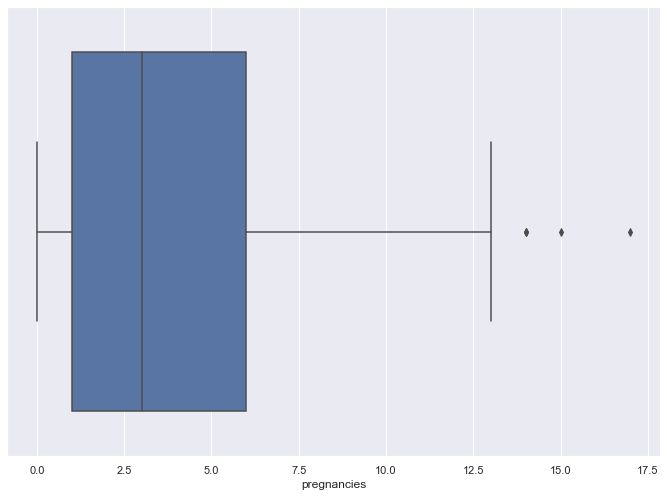

In [20]:
sns.boxplot(x = 'pregnancies', data = diabetes_df)

<AxesSubplot:xlabel='glucose'>

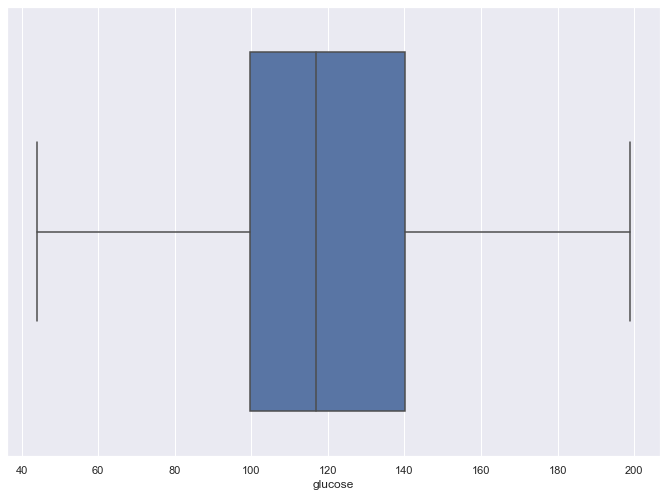

In [21]:
sns.boxplot(x = 'glucose', data = diabetes_df)

<AxesSubplot:xlabel='blood_pressure'>

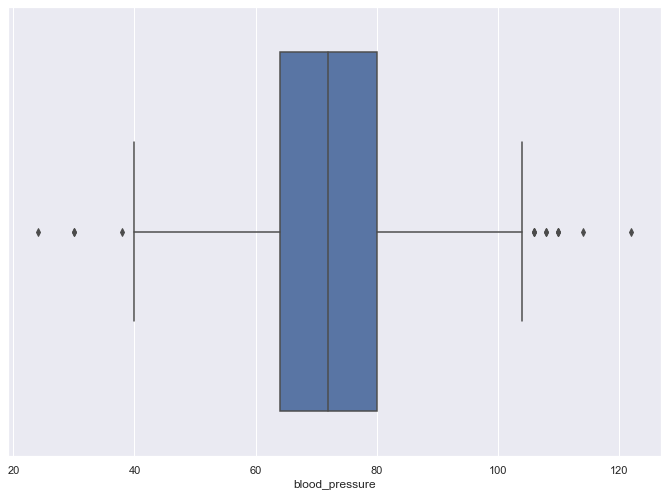

In [22]:
sns.boxplot(x = 'blood_pressure', data = diabetes_df)

<AxesSubplot:xlabel='bmi'>

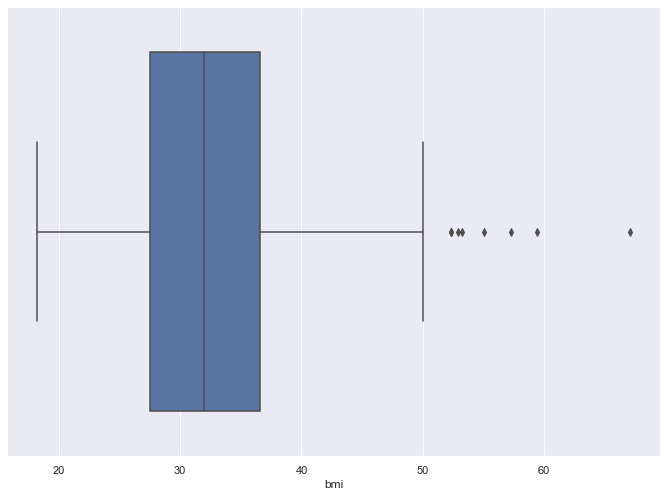

In [23]:
sns.boxplot(x = 'bmi', data = diabetes_df)

<AxesSubplot:xlabel='diabetes_pedigree_function'>

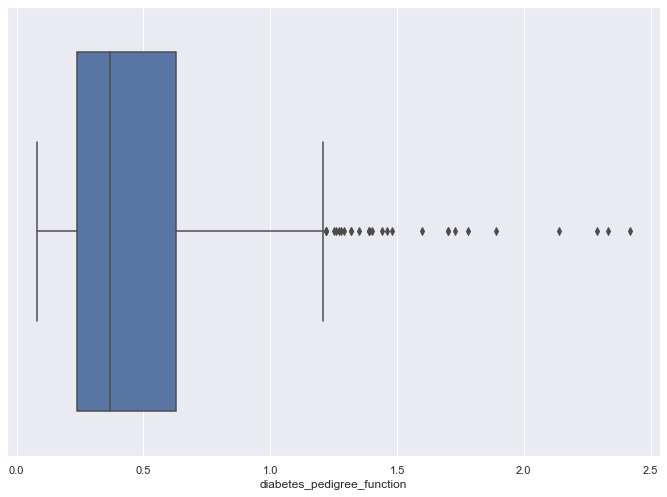

In [24]:
sns.boxplot(x = 'diabetes_pedigree_function', data = diabetes_df)

<AxesSubplot:xlabel='age'>

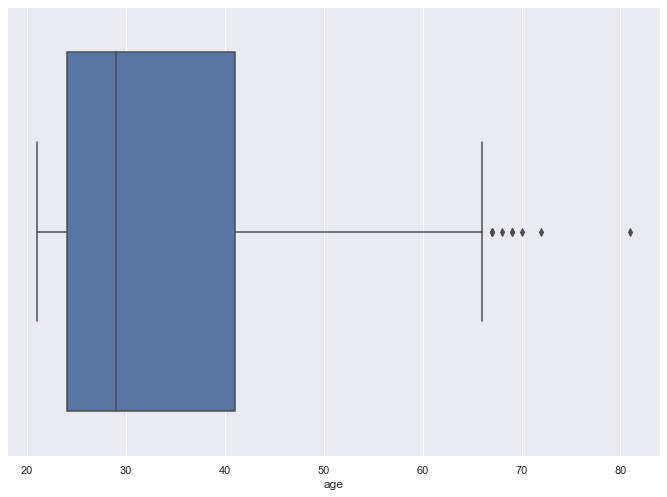

In [25]:
sns.boxplot(x = 'age', data = diabetes_df)

# Explore

- Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable). You can do this in the form of questions in a natural language (as opposed to "statistical" language).
- Visualize: use visualization techniques to identify drivers. When a visualization needs to be followed up with a statistical test, do so.
- Test your hypotheses when visualization isn't immediately clear. Use the appropriate statistical tests (t-tests, correlation, chi-square)

# Okeedokee, we got to know the data a bit, let's visualize the column data one by one and then ask some questions and make some visualizations!

### Visualize Univariate Distributions

array([[<AxesSubplot:title={'center':'pregnancies'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'diabetes_pedigree_function'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'outcome'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

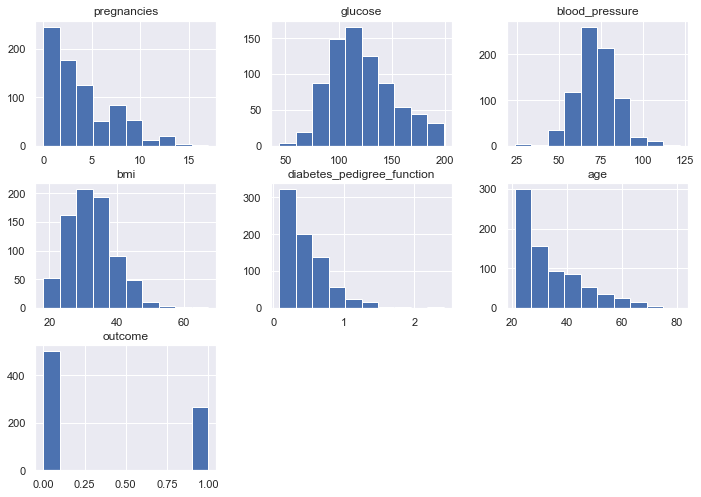

In [26]:
# use pandas hist()
diabetes_df.hist()

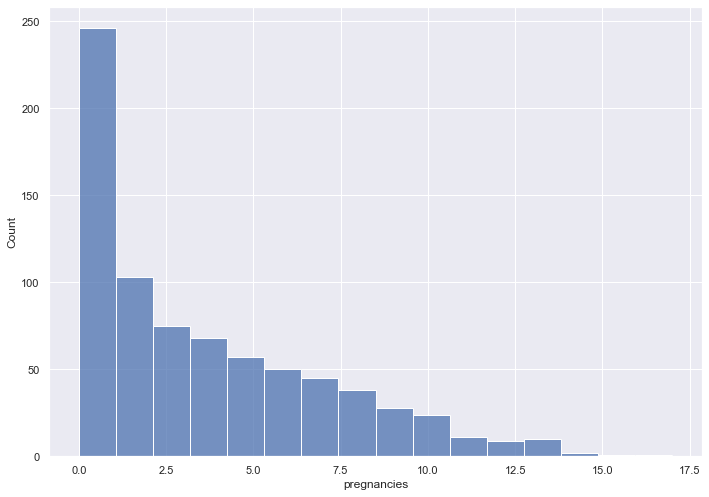

In [27]:
# using seaborn, create basic histograms for each column
sns.histplot(data=diabetes_df, x="pregnancies")
plt.show()

####  At least 4 pregnancies through childbearing age may be a potential risk factor for diabetes in postmenopausal women without a history of gestational diabetes.

In [28]:
# need to have a column with bins: 0 -3 pregnancies, 4 or more

In [29]:
labels =[0, 1]
diabetes_df['pregnancies_binned'] = pd.cut(diabetes_df['pregnancies'], bins=[0,4,16],labels=labels, include_lowest=True)

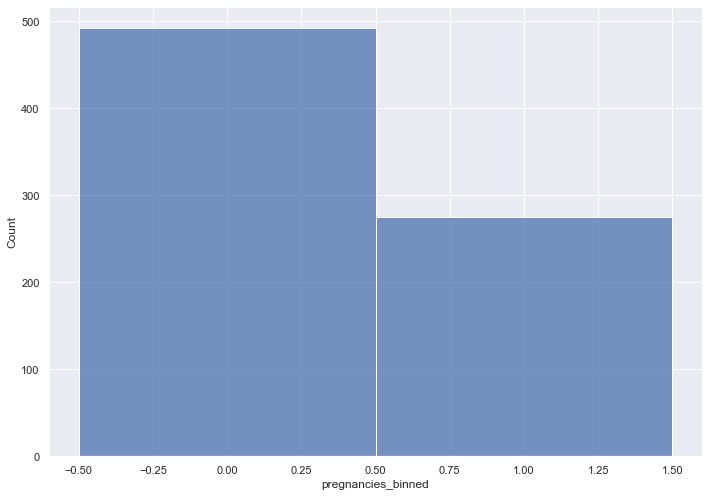

In [30]:
sns.histplot(data=diabetes_df, x="pregnancies_binned")
plt.show()

#### Oral glucose tolerance test.
##### At 2 hours, a blood sugar level of:
- 140 mg/dL or lower is considered normal
- 140 to 199 mg/dL indicates you have prediabetes and 
- 200 mg/dL or higher indicates you have diabetes.

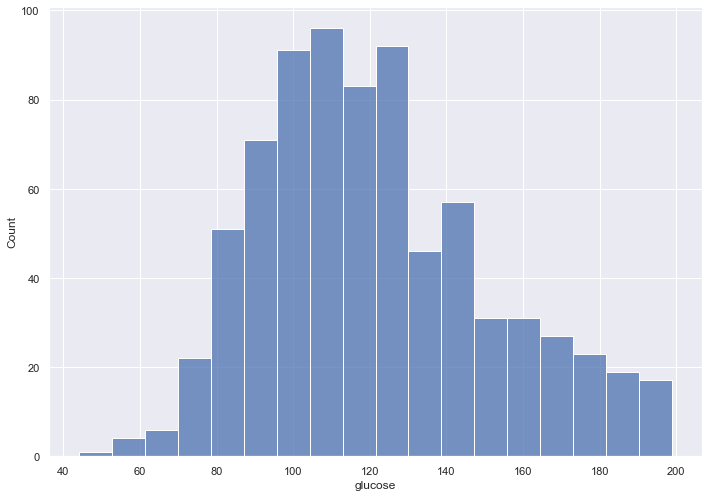

In [31]:
sns.histplot(data=diabetes_df, x="glucose")
plt.show()

In [32]:
# bin the glucose
labels =[0, 1]
diabetes_df['glucose_binned'] = pd.cut(diabetes_df['glucose'], bins=[0,140,200],labels=labels, include_lowest=True)

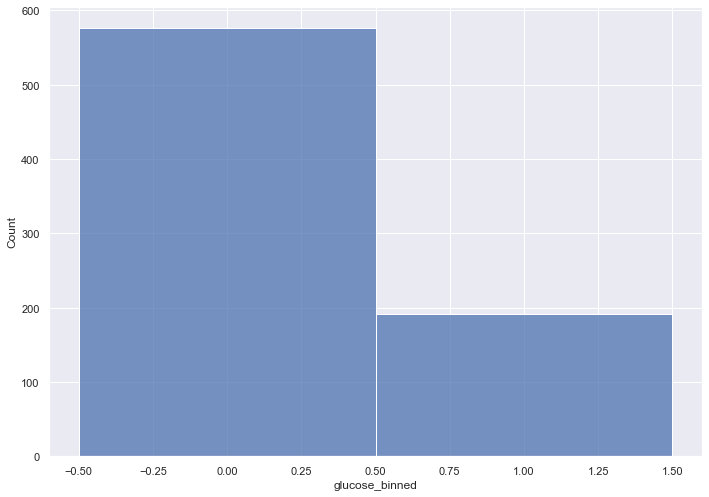

In [33]:
sns.histplot(data=diabetes_df, x="glucose_binned")
plt.show()


### Diabetes puts a strain on the kidneys which is evident when measuring blood pressure.  
- high blood pressure: 90 mm Hg or greater diastolic pressure
- prehypertension: 80 mm Hg – 89 mm Hg diastolic pressure
- normal blood pressure: Less than 80 mm Hg diastolic pressure

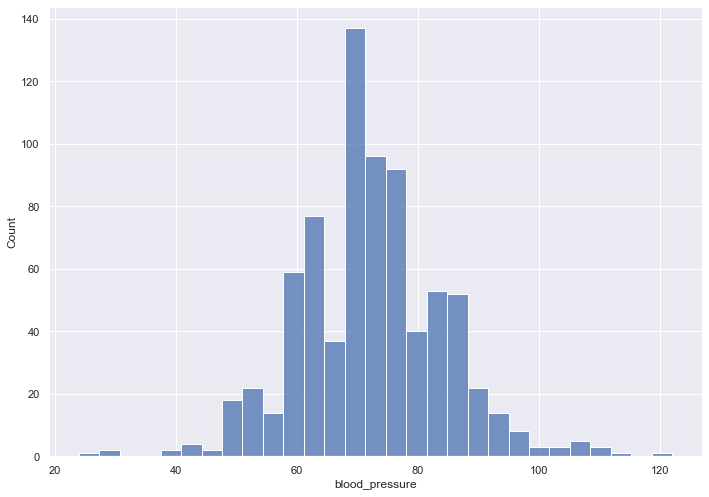

In [34]:
sns.histplot(data=diabetes_df, x="blood_pressure")
plt.show()

In [35]:
#bin the blood pressure
labels =[0, 1]
diabetes_df['bp_binned'] = pd.cut(diabetes_df['blood_pressure'], bins=[0,80,200],labels=labels, include_lowest=True)

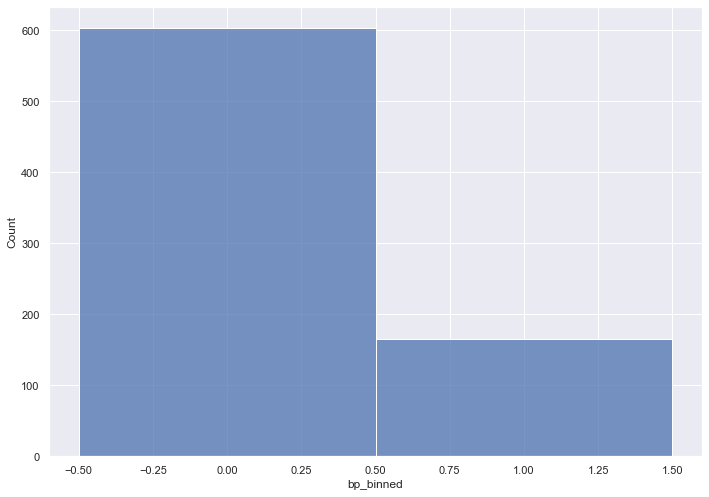

In [36]:
sns.histplot(data=diabetes_df, x="bp_binned")
plt.show()

#### BMI is a complicated number that may indicate a number of comorbidities.  So again a higher number predisposses you to diabtetes. Major adult BMI classifications are underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more)

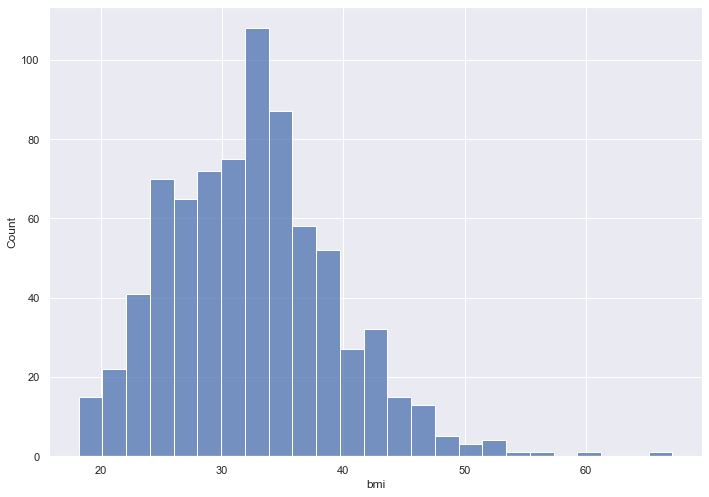

In [37]:
sns.histplot(data=diabetes_df, x="bmi")
plt.show()

In [38]:
#bin the bmi
labels =[0, 1]
diabetes_df['bmi_binned'] = pd.cut(diabetes_df['bmi'], bins=[0,24.9,60],labels=labels, include_lowest=True)

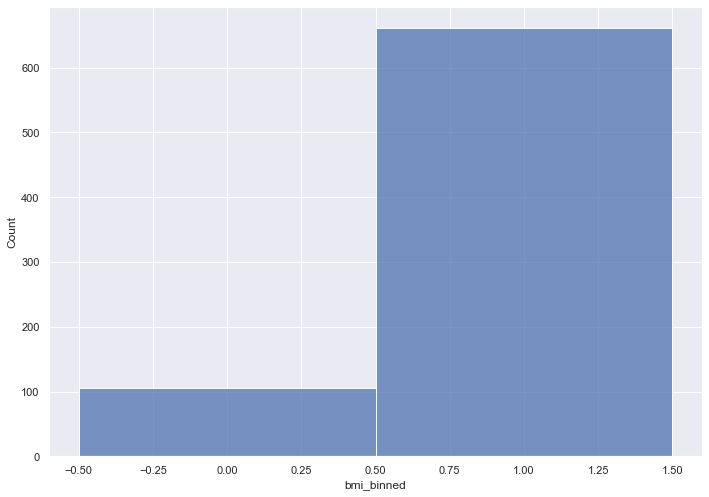

In [39]:
sns.histplot(data=diabetes_df, x="bmi_binned")
plt.show()

### The Diabetes Pedigree Function is a function which scores likelihood of diabetes based on family history, so higher numbers indicate that you may more predisposed to diabetes.¶

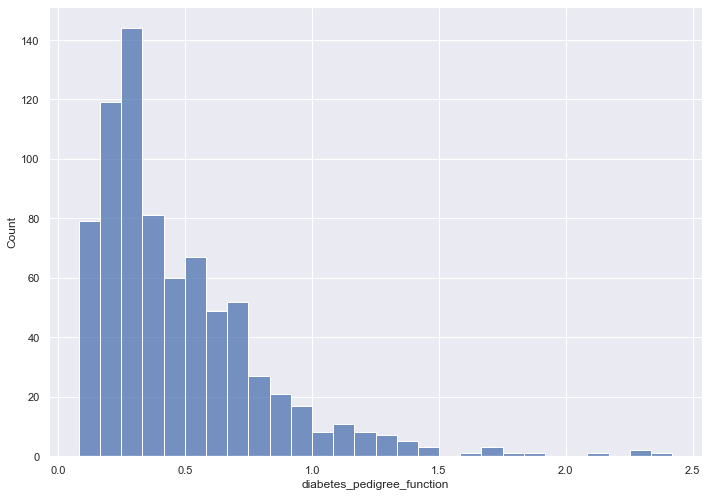

In [40]:
sns.histplot(data=diabetes_df, x="diabetes_pedigree_function")
plt.show()

#### age is spread between 21-66, more patients are younger.  At least 4 pregnancies through childbearing age may be a potential risk factor for diabetes in postmenopausal women without a history of gestational diabetes.



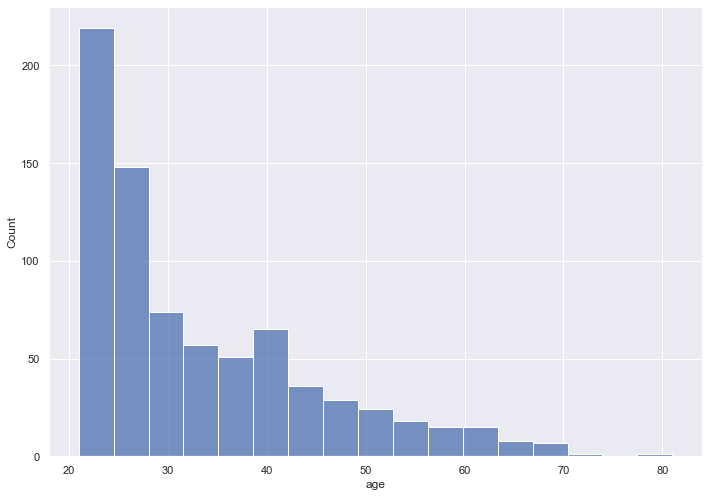

In [41]:
sns.histplot(data=diabetes_df, x="age")
plt.show()

In [42]:
#bin the bmi
labels =[0, 1]
diabetes_df['age_binned'] = pd.cut(diabetes_df['age'], bins=[0,45,85],labels=labels, include_lowest=True)

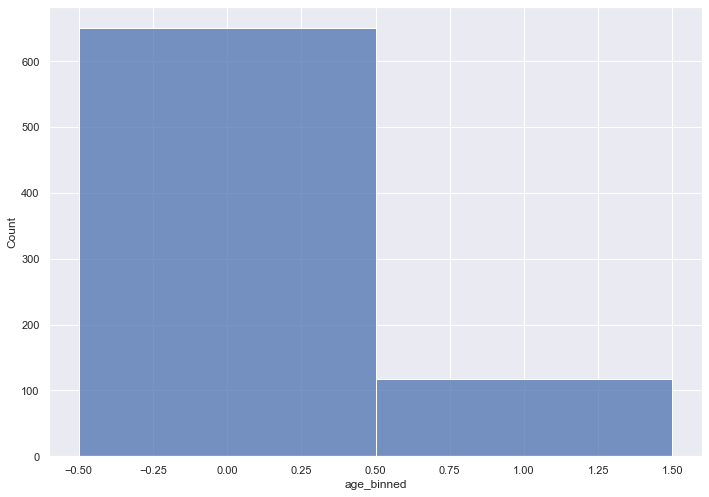

In [43]:
sns.histplot(data=diabetes_df, x="age_binned")
plt.show()

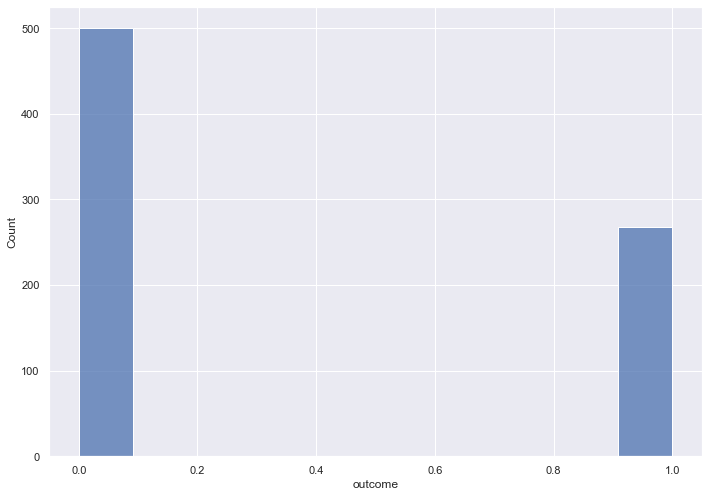

In [44]:
sns.histplot(data=diabetes_df, x="outcome")
plt.show()

In [45]:
diabetes_df.outcome.value_counts()

0    500
1    268
Name: outcome, dtype: int64

### changed the data type of the binned columns to int64

In [46]:
diabetes_df["pregnancies_binned"] = diabetes_df["pregnancies_binned"].astype("float")

In [47]:
diabetes_df["glucose_binned"] = diabetes_df["glucose_binned"].astype("float")

In [48]:
diabetes_df["bp_binned"] = diabetes_df["bp_binned"].astype("float")

In [49]:
diabetes_df["bmi_binned"] = diabetes_df["bmi_binned"].astype("float")

In [50]:
diabetes_df["age_binned"] = diabetes_df["age_binned"].astype("float")

array([[<AxesSubplot:title={'center':'pregnancies'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'diabetes_pedigree_function'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'outcome'}>,
        <AxesSubplot:title={'center':'pregnancies_binned'}>,
        <AxesSubplot:title={'center':'glucose_binned'}>],
       [<AxesSubplot:title={'center':'bp_binned'}>,
        <AxesSubplot:title={'center':'bmi_binned'}>,
        <AxesSubplot:title={'center':'age_binned'}>]], dtype=object)

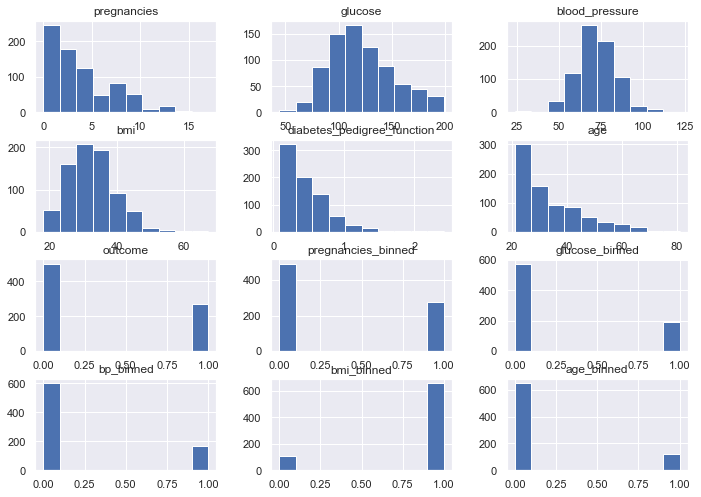

In [51]:
# use pandas hist()
diabetes_df.hist()

### After exploring univariates, BUT before exploring bivariate or multivariate, split into train, validate, test.  Only explore on train.

In [52]:
def split_diabetes(df):
    '''
    This function performs split on diabetes data, stratify outcome.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(diabetes_df, test_size=.2, 
                                        random_state=123, 
                                        stratify=diabetes_df.outcome)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.outcome)
    return train, validate, test

#train, validate, test= split_diabetes(df) 

In [53]:
train, validate, test= split_diabetes(diabetes_df) 

In [97]:
train.head(25)

,pregnancies,glucose,blood_pressure,bmi,diabetes_pedigree_function,age,outcome,pregnancies_binned,glucose_binned,bp_binned,bmi_binned,age_binned
647,0,179.0,50.00,37.80,0.46,22,1,0.0,1.0,0.0,1.0,0.0
320,4,129.0,60.00,27.50,0.53,31,0,0.0,0.0,0.0,1.0,0.0
522,6,114.0,69.11,31.99,0.19,26,0,1.0,0.0,0.0,1.0,0.0
453,2,119.0,69.11,19.60,0.83,72,0,0.0,0.0,0.0,0.0,1.0
17,7,107.0,74.00,29.60,0.25,31,1,1.0,0.0,0.0,1.0,0.0
60,2,84.0,69.11,31.99,0.30,21,0,0.0,0.0,0.0,1.0,0.0
287,1,119.0,86.00,45.60,0.81,29,1,0.0,0.0,1.0,1.0,0.0
275,2,100.0,70.00,40.50,0.68,25,0,0.0,0.0,0.0,1.0,0.0
587,6,103.0,66.00,24.30,0.25,29,0,1.0,0.0,0.0,0.0,0.0
245,9,184.0,85.00,30.00,1.21,49,1,1.0,1.0,1.0,1.0,1.0


# bivariate analysis, comparing to columns to eachother

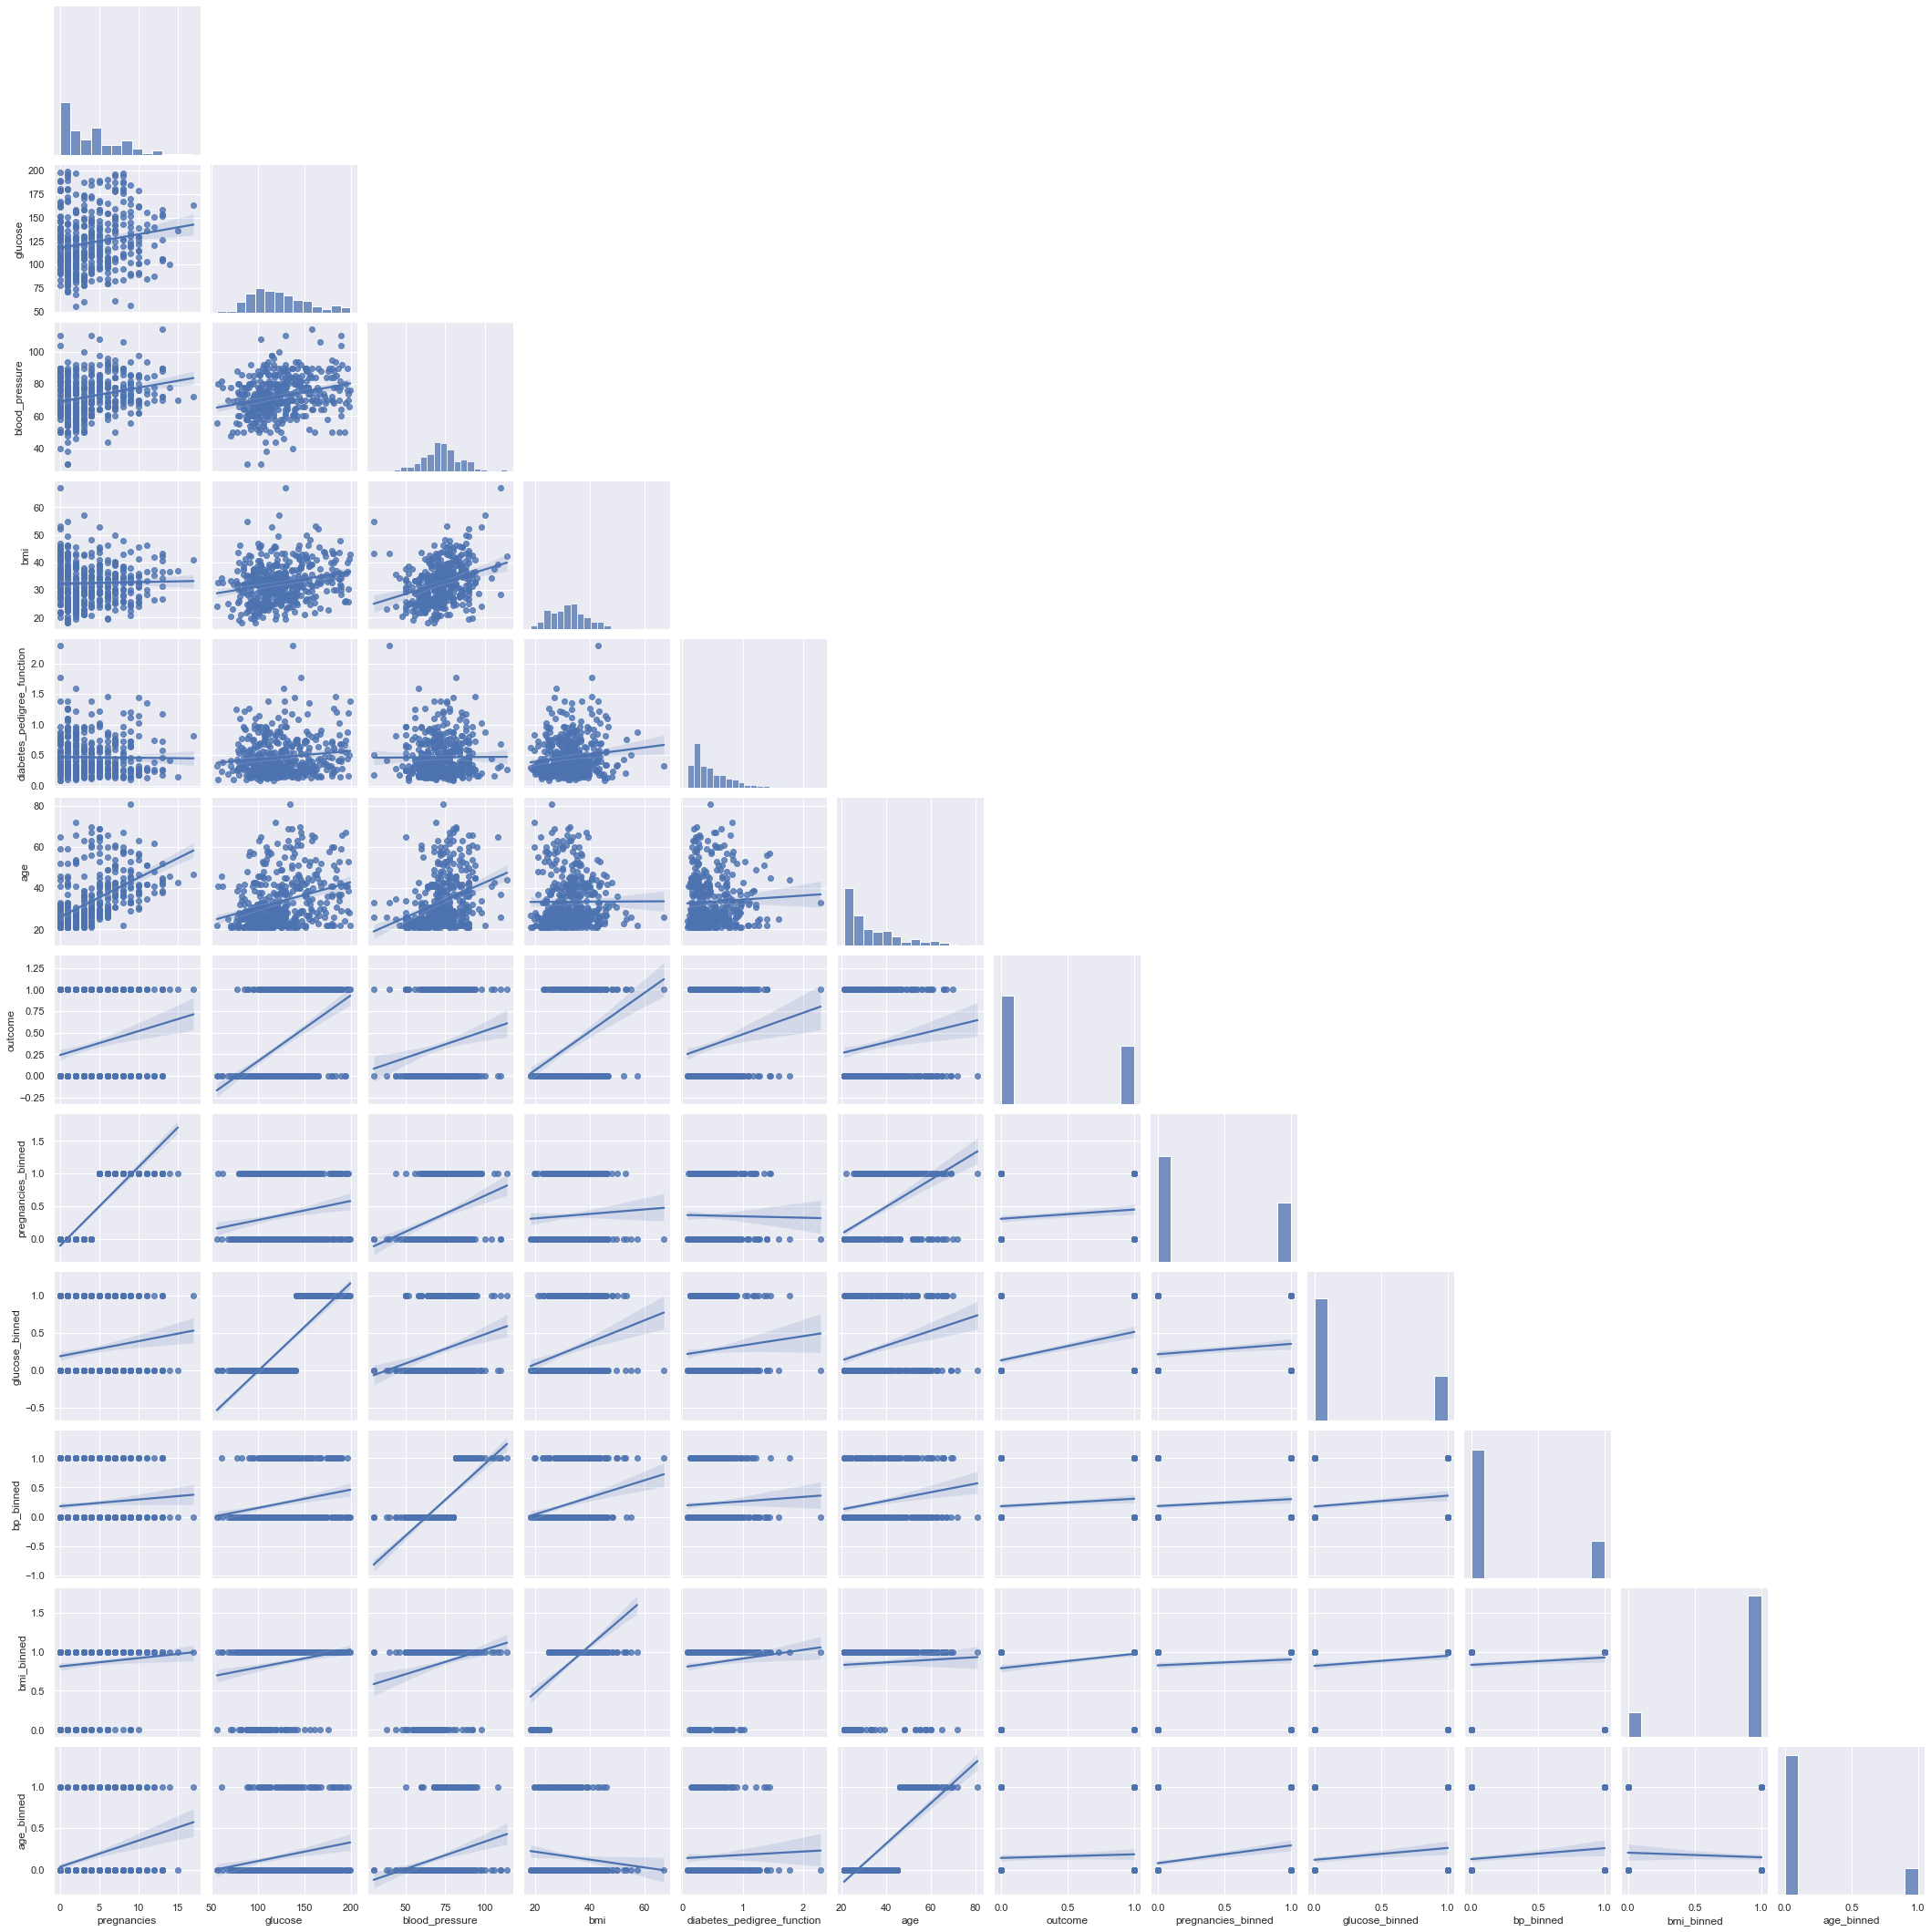

In [55]:
# compare the columns to each other
sns.pairplot(data=train, kind="reg", corner=True)

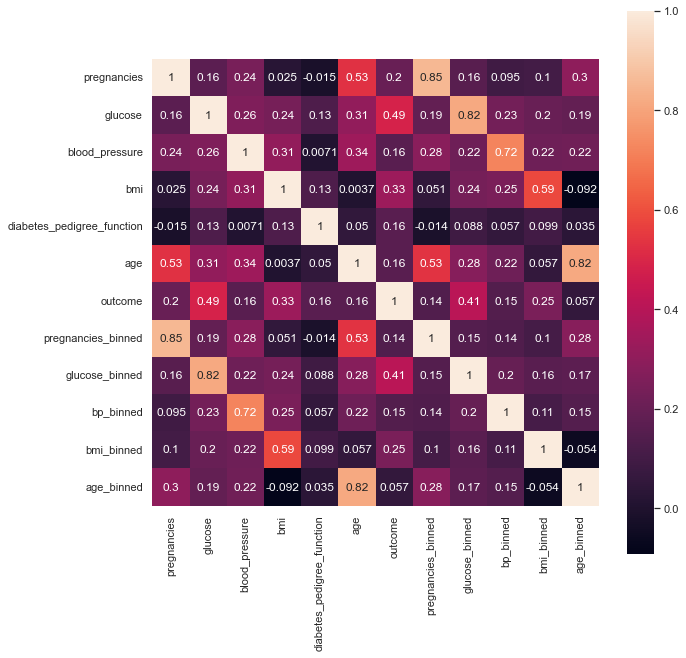

In [56]:
fig, ax = plt.subplots(figsize=(10,10))      
corr = train.corr()
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.show()

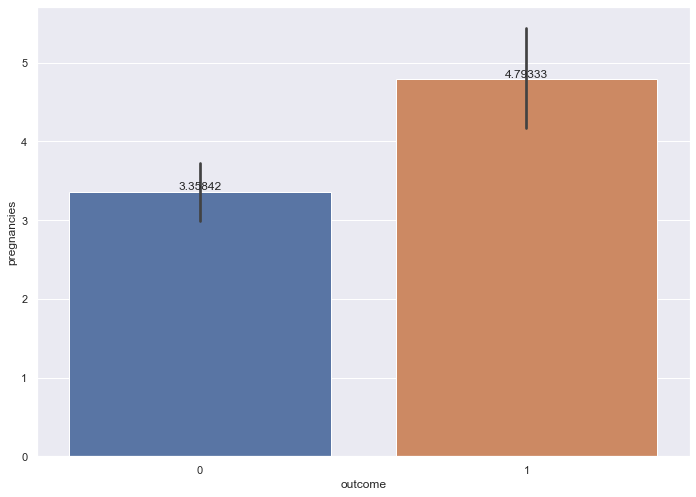

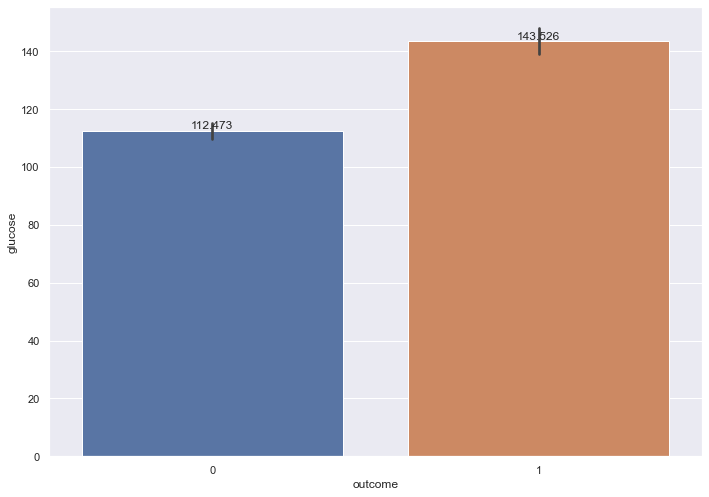

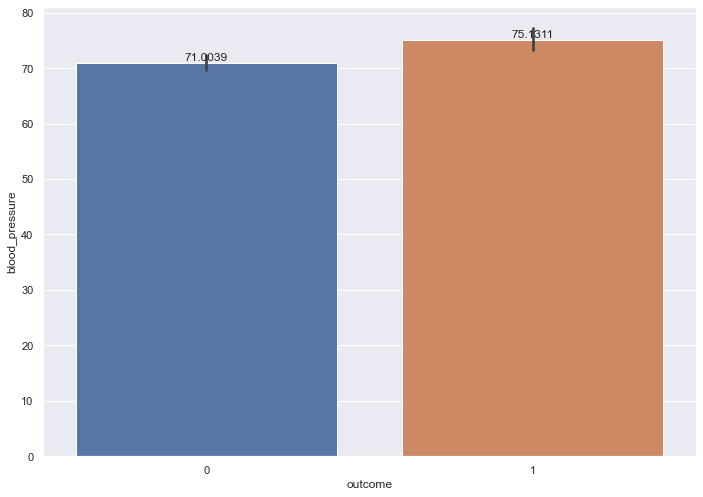

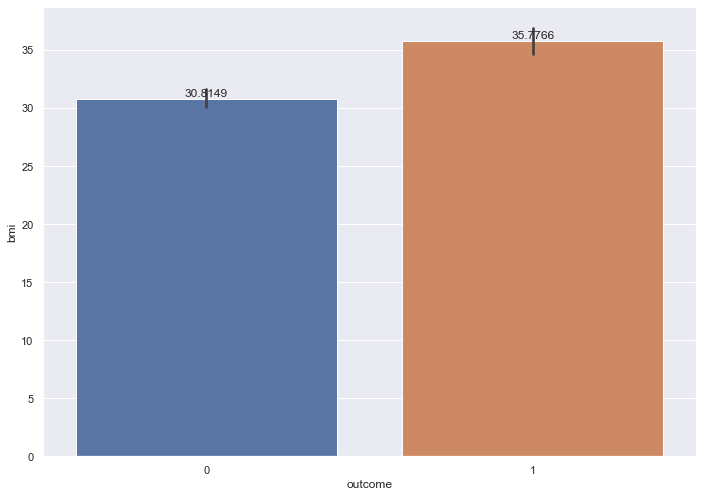

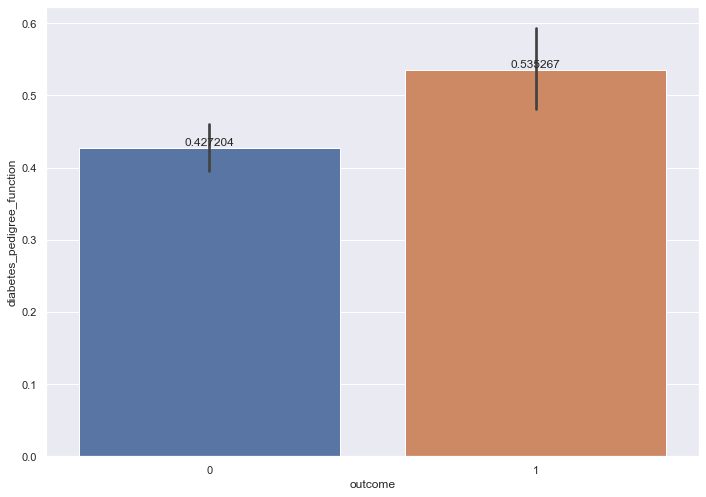

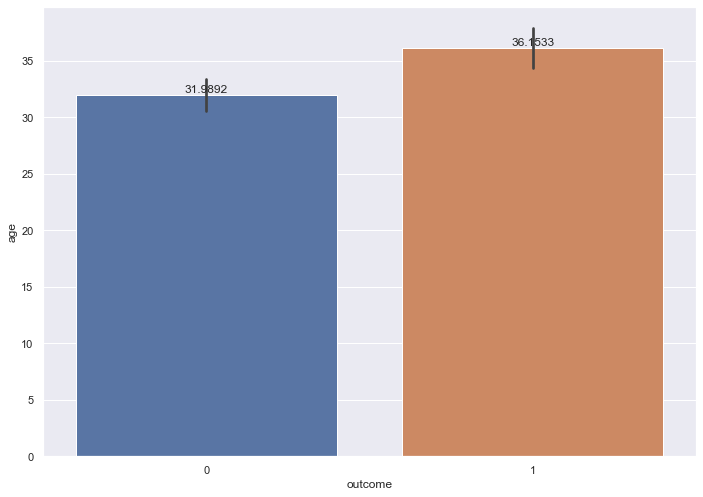

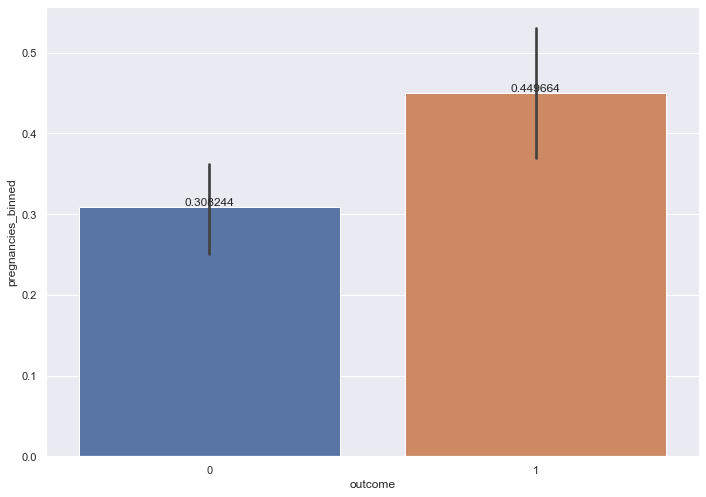

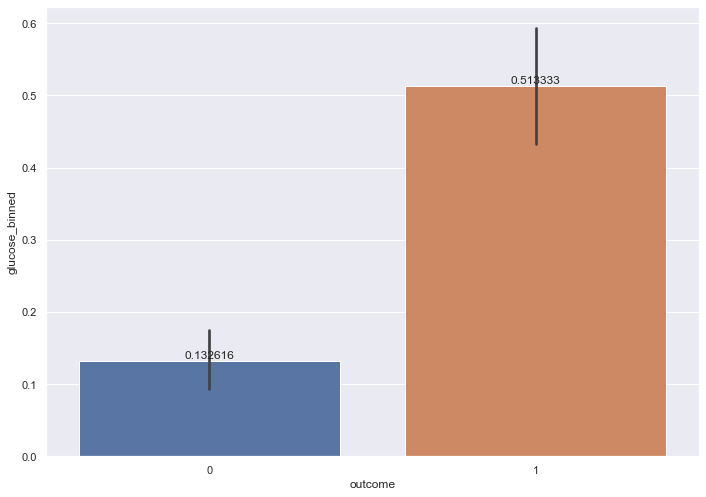

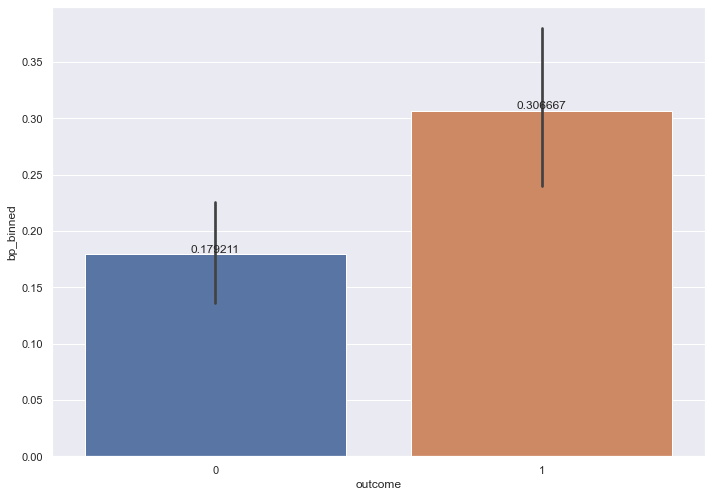

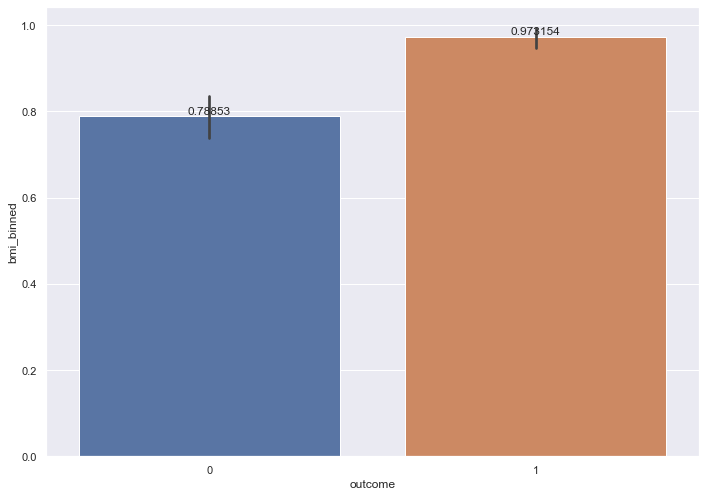

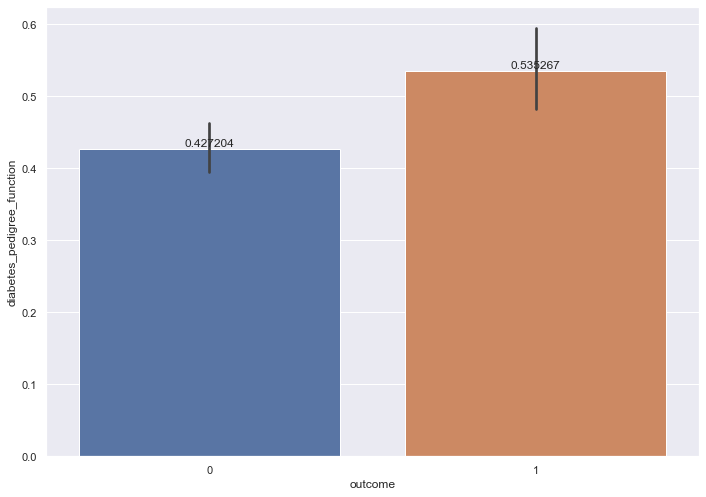

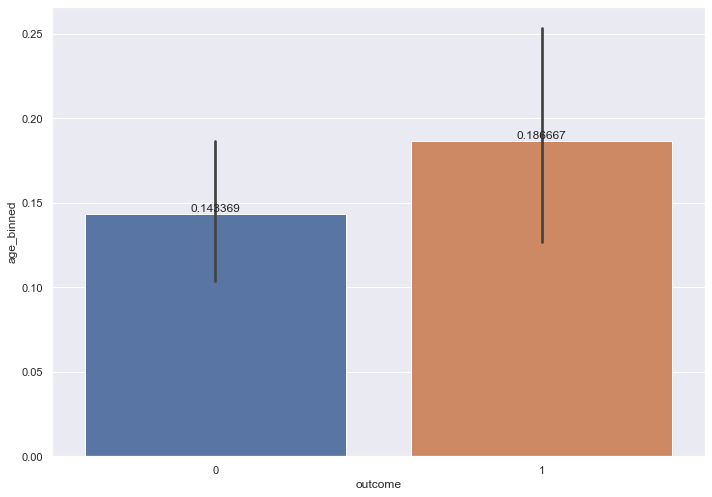

In [104]:
measurements = ['pregnancies','glucose','blood_pressure','bmi','diabetes_pedigree_function','age', 'pregnancies_binned','glucose_binned','bp_binned','bmi_binned','diabetes_pedigree_function','age_binned']
for col in measurements:
    ax=sns.barplot(data=train, x='outcome', y=col)
    for i in ax.containers:
        ax.bar_label(i,)
        plt.show()

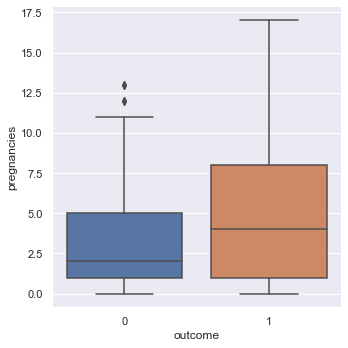

In [59]:
sns.catplot(data=train, x="outcome", y="pregnancies", kind="box")

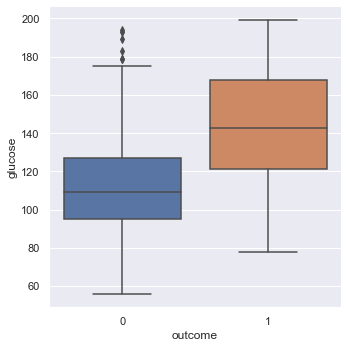

In [60]:
sns.catplot(data=train, x="outcome", y="glucose", kind="box")

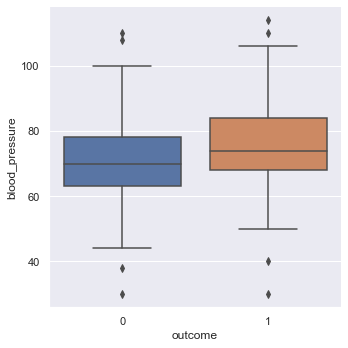

In [61]:
sns.catplot(data=train, x="outcome", y="blood_pressure", kind="box")

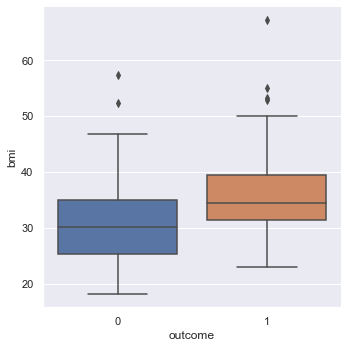

In [62]:
sns.catplot(data=train, x="outcome", y="bmi", kind="box")

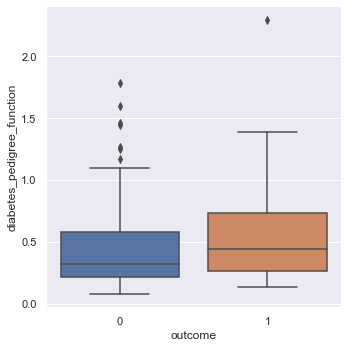

In [63]:
sns.catplot(data=train, x="outcome", y="diabetes_pedigree_function", kind="box")

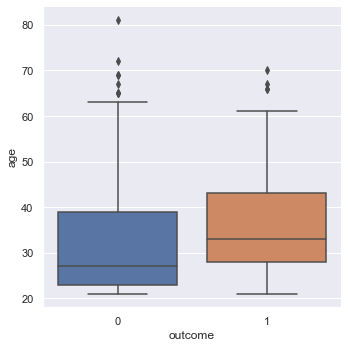

In [64]:
sns.catplot(data=train, x="outcome", y="age", kind="box")

# Comparing each variable to target variable.
### Takeaway:
- the outcome of 1, diabetic, showed that independent variable was more likely to indicate diabetes if its number was higher
- basically the higher the patients age, glucose levels, bmi, blood pressure, diabetes pedigree function, and number of pregnancies, the more likely your chance is to be a diabetic

# QUESTIONS???

### At least 4 pregnancies through childbearing age may be a potential risk factor for diabetes in postmenopausal women without a history of gestational diabetes.  
### Does the number of pregnancies (4 or more) for older women create a diabetic outcome?')

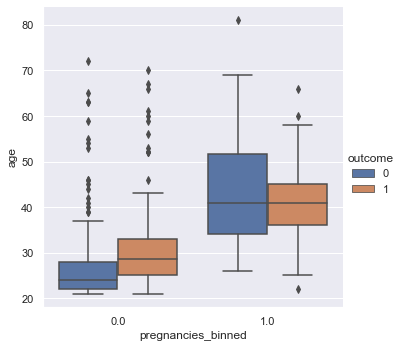

In [65]:
sns.catplot(data=train, x="pregnancies_binned", y="age", hue="outcome", kind="box")

### Viz takeway:If you are older and you have had four or more pregnancies, you are more likely to be diabetic.

### At 2 hours, a blood sugar level of 140 mg/dL or lower is considered normal, 140 to 199 mg/dL indicates you have prediabetes, and 200 mg/dL or higher indicates you have diabetes.  

### Do both high glucose and a diabetes pedigree function  make having diabetes inevitable?


<AxesSubplot:xlabel='glucose', ylabel='diabetes_pedigree_function'>

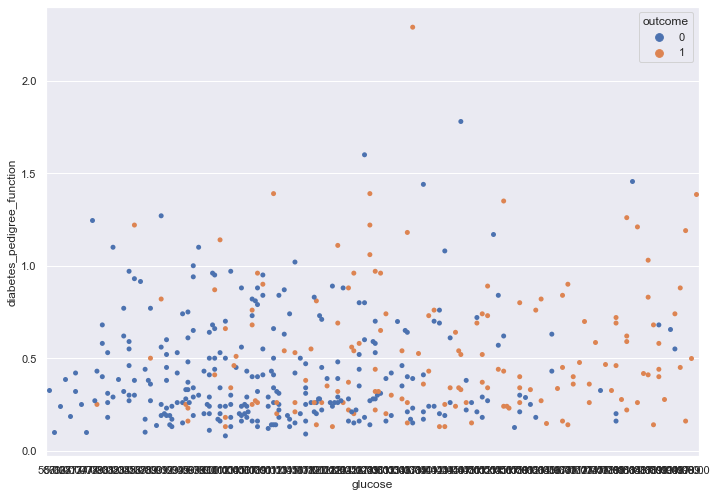

In [101]:
sns.swarmplot(data=train, x="glucose", y="diabetes_pedigree_function", hue="outcome")

### Viz takeway: higher glucose levels and higher pedigree is shown on the graph with the denser color on the diabetic side

### Does having both a high glucose and and high BMI have a relationship with outcome? 

### Viz takeway: higher glucose levels and higher bmi is shown on the graph with the denser color on the diabetic side

[Text(0.5, 1.0, 'Does having both a high glucose and and high BMI have a relationship with outcome?')]

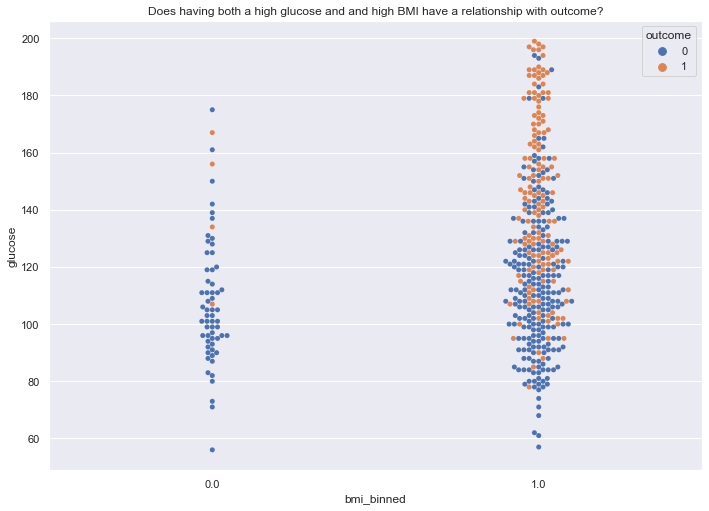

In [68]:
sns.swarmplot(x='bmi_binned', y='glucose', hue='outcome', data=train).set(title='Does having both a high glucose and and high BMI have a relationship with outcome?')


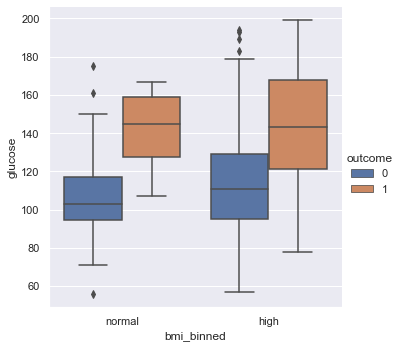

In [69]:
sns.catplot(data=train, x="bmi_binned", y="glucose", hue="outcome", kind="box").set_xticklabels(labels=['normal', 'high'])

### Viz takeway: These are the best visualizations.  The combination of both higher glucose levels and bmi points to being a diabetic more than the other combinations.

### Does blood pressure and diabetes pedigree function lead to diabetes?

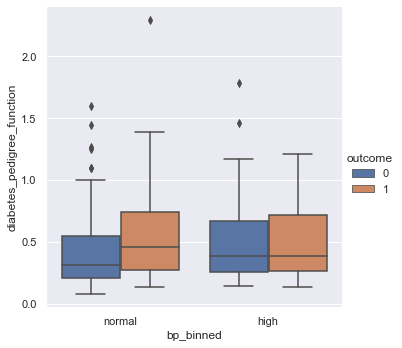

In [70]:
sns.catplot(data=train, x="bp_binned", y="diabetes_pedigree_function", hue="outcome", kind="box").set_xticklabels(labels=['normal', 'high'])

### Viz takeway: Nothing much is different between the 2 independent variables and outcome.

<AxesSubplot:xlabel='bmi_binned', ylabel='glucose_binned'>

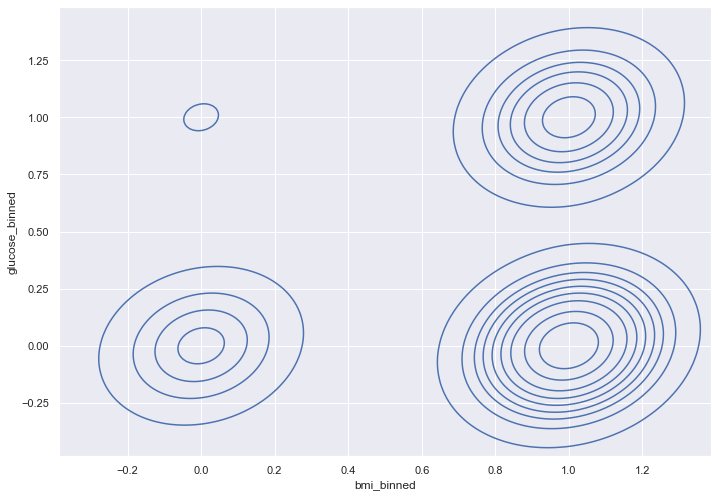

In [71]:
sns.kdeplot(data=train, x='bmi_binned', y='glucose_binned')

In [72]:
pd.crosstab(train.bmi_binned, train.glucose_binned)

glucose_binned,0.0,1.0
bmi_binned,,
0.0,57,6
1.0,257,108


In [108]:

cats = ['pregnancies', 'age','pregnancies_binned', 'age_binned', 'bp_binned', 'bmi_binned', 'glucose_binned']
nums = ['glucose','blood_pressure','bmi','diabetes_pedigree_function']
target = 'outcome'

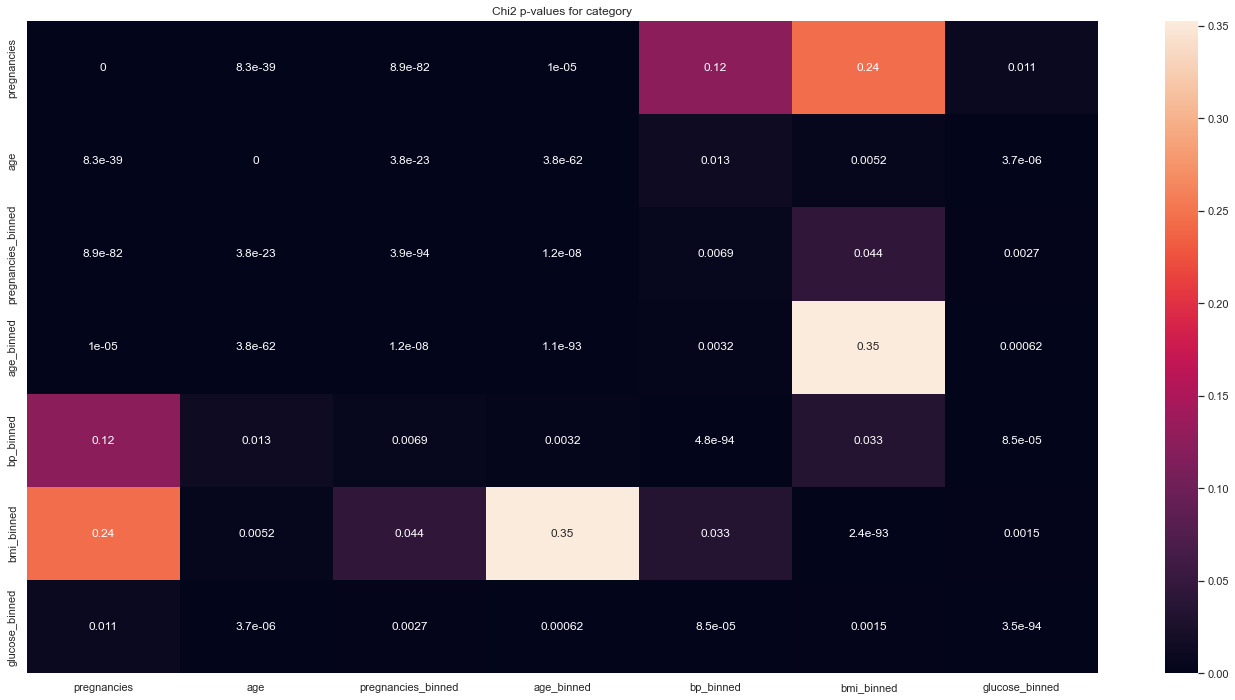

In [109]:
c = []
for col in cats:
    d = []
    for spot in cats:
        alpha = 0.05
        o = pd.crosstab(train[col], train[spot])
        chi2, p, dof, e = stats.chi2_contingency(o)
        d.append(p)
    c.append(d)
c = pd.DataFrame(c)
plt.figure(figsize=(24,12))
sns.heatmap(c, xticklabels=cats, yticklabels=cats, annot=True, fmt='.2g')
plt.title('Chi2 p-values for category')
plt.show()

In [110]:
def explore_cats(train, cats, target):
    '''
    This function takes:
            train = train DataFrame
            cats = category columns (as a list of strings)
            target = target variable (as a string)
    prints value counts for each category in each column
    '''
    for col in cats:
        print(col)
        print(train[col].value_counts())
        print(train[col].value_counts(normalize=True)*100)
        sns.countplot(x=col, data=train)
        plt.title(col+' counts')
        plt.show()
    
        sns.barplot(data=train, x=col, y=target)
        rate = train[target].mean()
        plt.axhline(rate, label= 'average ' + target + ' rate')
        plt.legend()
        plt.title(target+' rate by '+col)
        plt.show()
    
        alpha = 0.05
        o = pd.crosstab(train[col], train[target])
        chi2, p, dof, e = stats.chi2_contingency(o)
        result = p < alpha
        print('P is less than alpha: '+result.astype('str'))
        print('------------------------------------------------------------')

pregnancies
1     73
0     63
2     63
3     40
4     36
5     34
7     25
6     24
8     19
9     18
10    15
13     7
11     5
12     4
14     1
15     1
17     1
Name: pregnancies, dtype: int64
1     17.016317
0     14.685315
2     14.685315
3      9.324009
4      8.391608
5      7.925408
7      5.827506
6      5.594406
8      4.428904
9      4.195804
10     3.496503
13     1.631702
11     1.165501
12     0.932401
14     0.233100
15     0.233100
17     0.233100
Name: pregnancies, dtype: float64


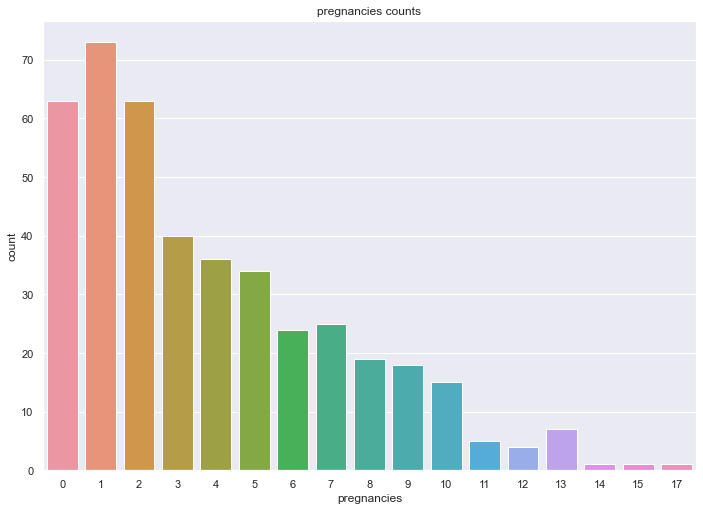

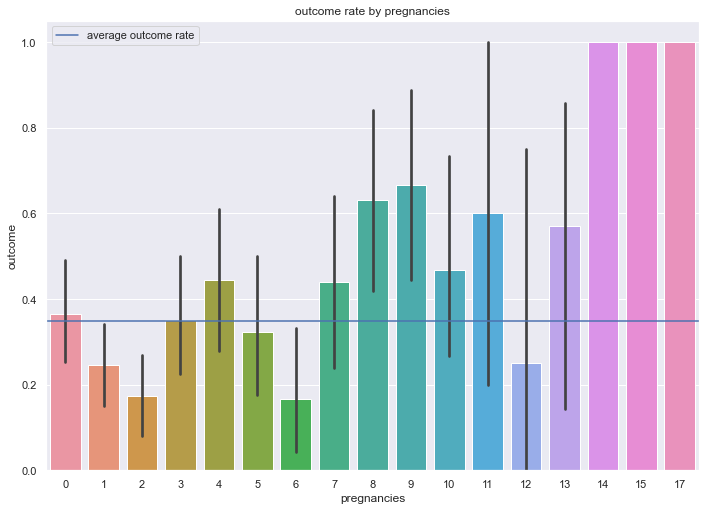

P is less than alpha: True
------------------------------------------------------------
age
22    45
21    35
25    26
24    26
28    24
26    19
27    18
29    17
23    17
41    15
31    12
30    11
43    10
33    10
37    10
32     9
39     9
36     9
42     8
45     8
34     7
38     6
46     5
40     5
60     5
53     4
52     4
58     4
51     4
63     4
49     4
48     3
57     3
35     3
47     3
65     3
54     3
67     2
44     2
69     2
59     2
55     2
56     2
66     2
61     2
70     1
81     1
62     1
50     1
72     1
Name: age, dtype: int64
22    10.489510
21     8.158508
25     6.060606
24     6.060606
28     5.594406
26     4.428904
27     4.195804
29     3.962704
23     3.962704
41     3.496503
31     2.797203
30     2.564103
43     2.331002
33     2.331002
37     2.331002
32     2.097902
39     2.097902
36     2.097902
42     1.864802
45     1.864802
34     1.631702
38     1.398601
46     1.165501
40     1.165501
60     1.165501
53     0.932401
52     0.932401
58

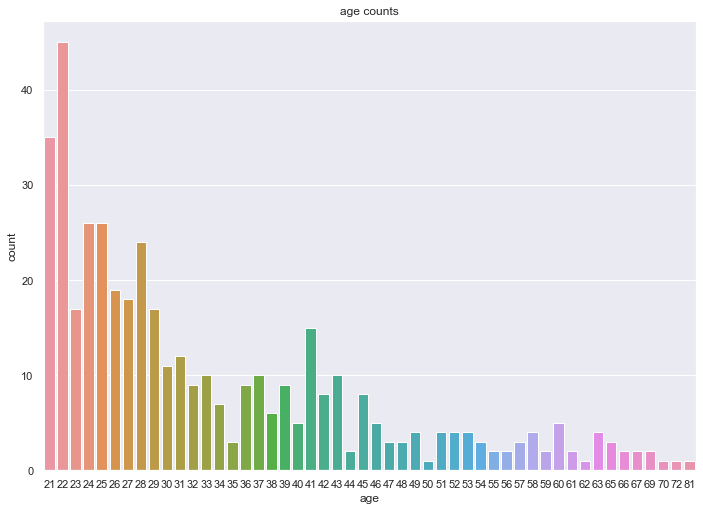

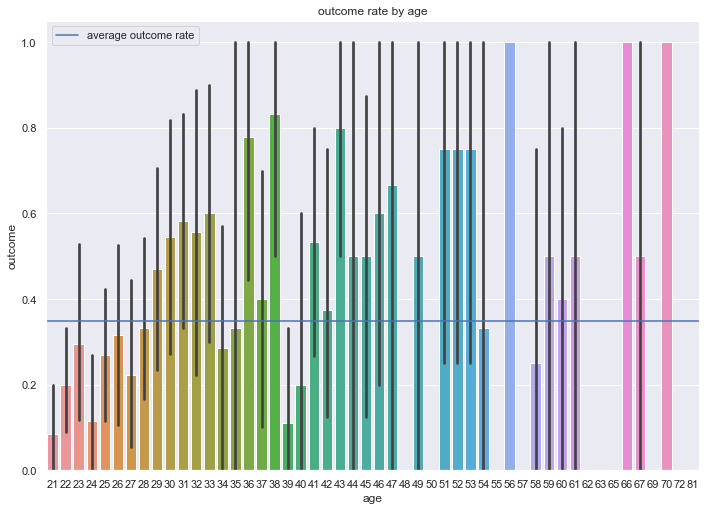

P is less than alpha: True
------------------------------------------------------------
pregnancies_binned
0.0    275
1.0    153
Name: pregnancies_binned, dtype: int64
0.0    64.252336
1.0    35.747664
Name: pregnancies_binned, dtype: float64


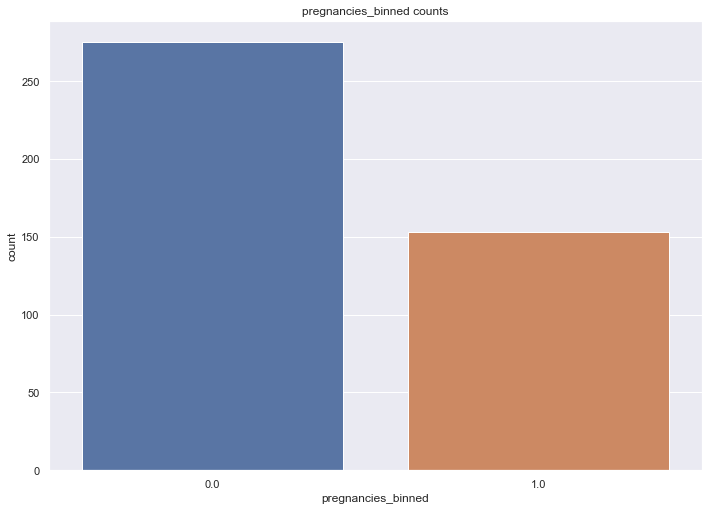

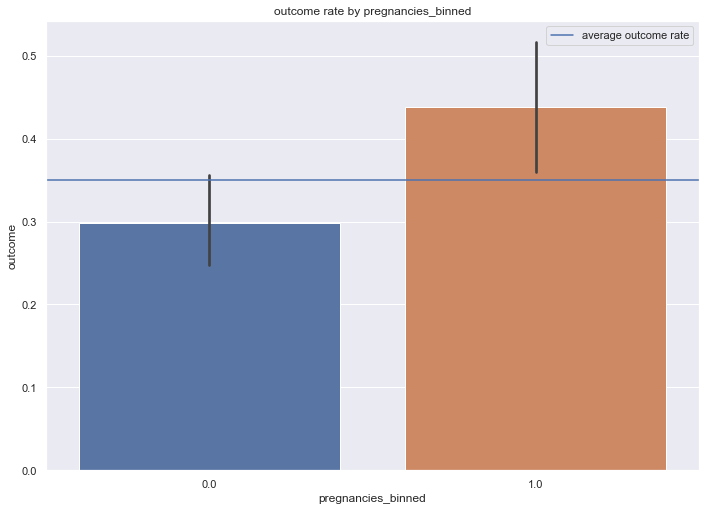

P is less than alpha: True
------------------------------------------------------------
age_binned
0.0    361
1.0     68
Name: age_binned, dtype: int64
0.0    84.149184
1.0    15.850816
Name: age_binned, dtype: float64


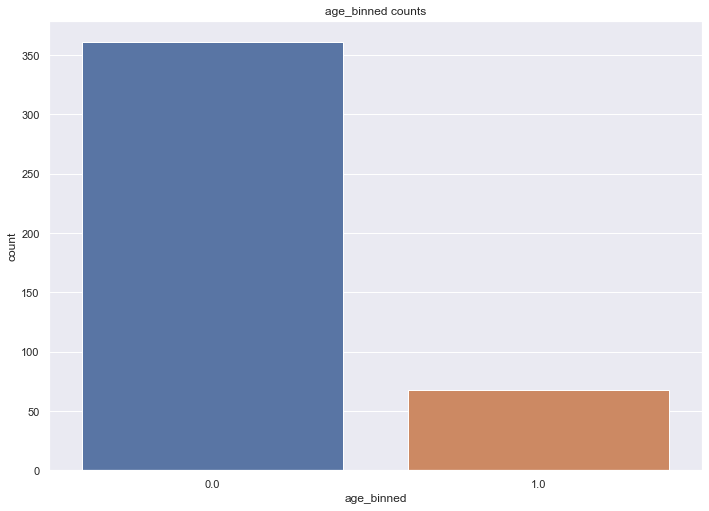

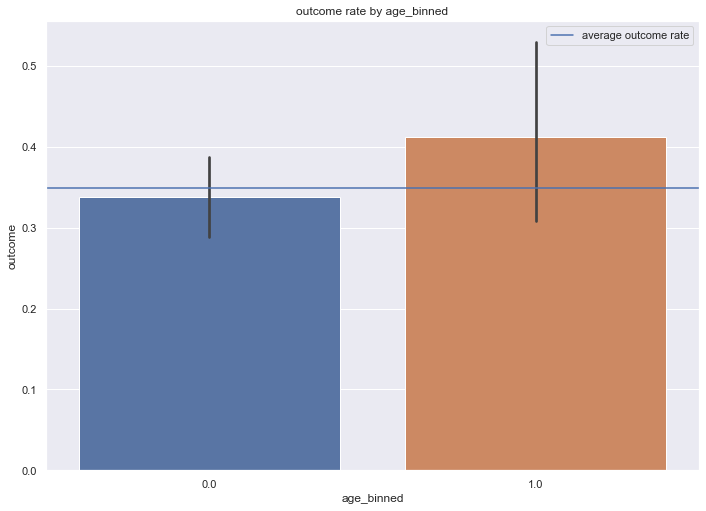

P is less than alpha: False
------------------------------------------------------------
bp_binned
0.0    333
1.0     96
Name: bp_binned, dtype: int64
0.0    77.622378
1.0    22.377622
Name: bp_binned, dtype: float64


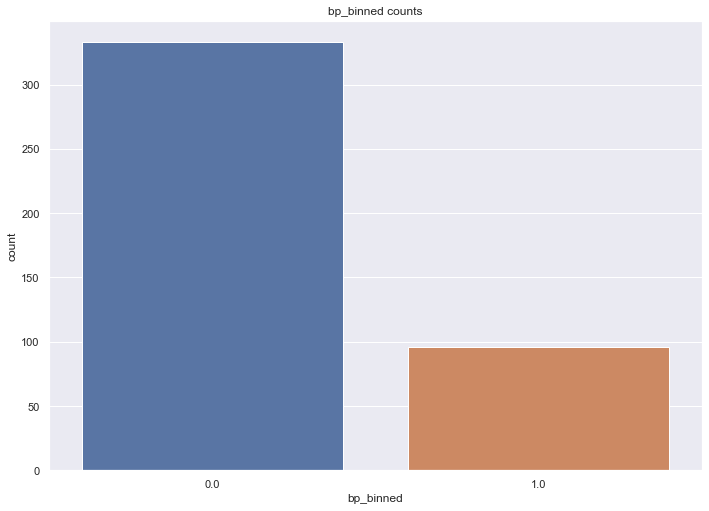

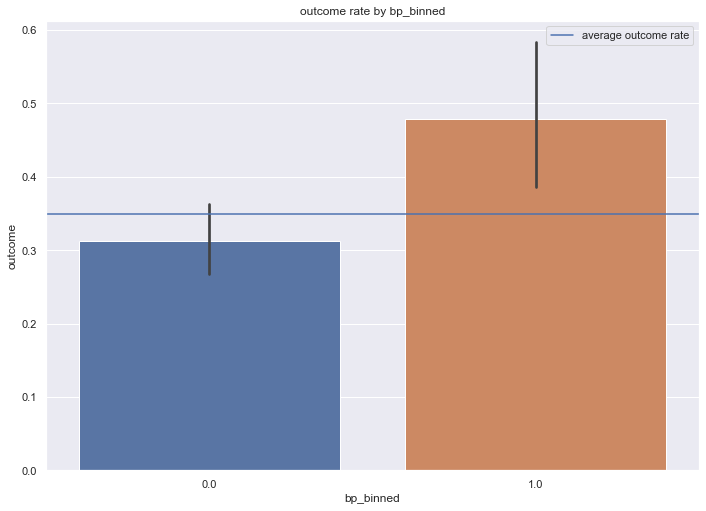

P is less than alpha: True
------------------------------------------------------------
bmi_binned
1.0    365
0.0     63
Name: bmi_binned, dtype: int64
1.0    85.280374
0.0    14.719626
Name: bmi_binned, dtype: float64


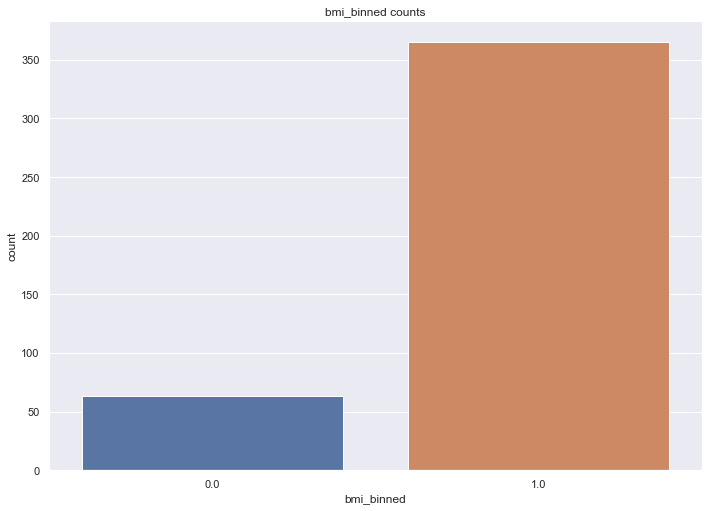

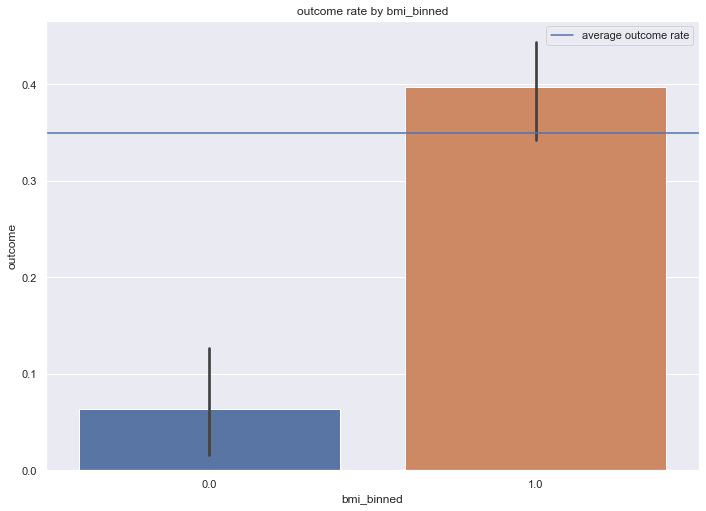

P is less than alpha: True
------------------------------------------------------------
glucose_binned
0.0    315
1.0    114
Name: glucose_binned, dtype: int64
0.0    73.426573
1.0    26.573427
Name: glucose_binned, dtype: float64


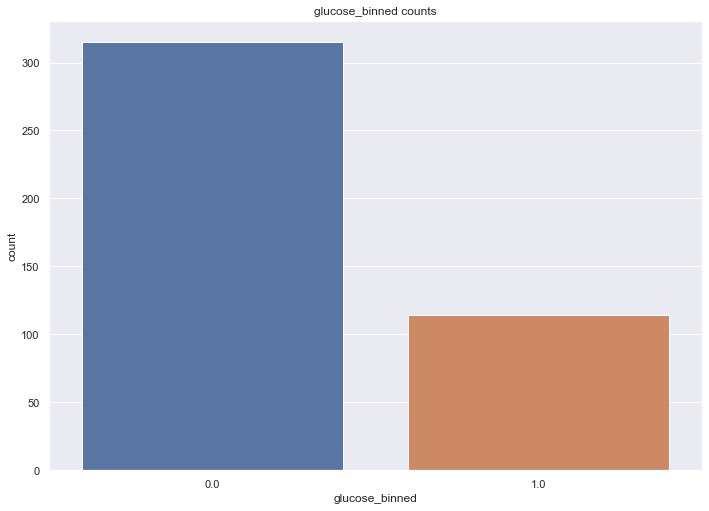

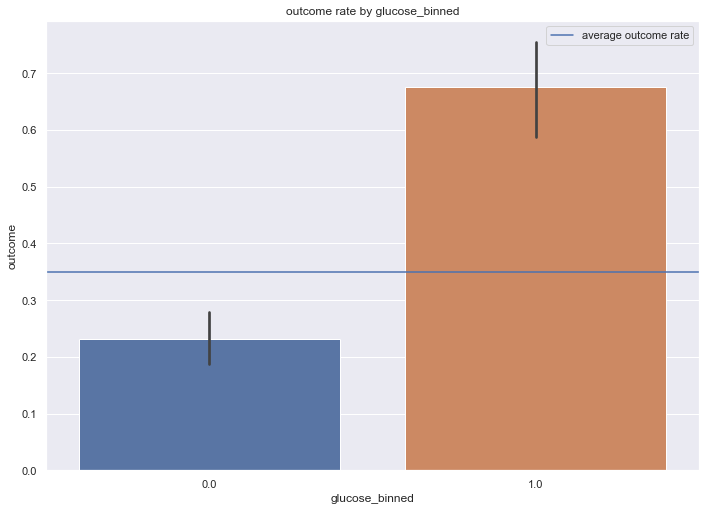

P is less than alpha: True
------------------------------------------------------------


In [111]:
explore_cats(train, cats, 'outcome')

In [112]:
def explore_nums(train, nums):
    '''
    This function takes in:
            train = train DataFrame
            nums = numerical columns (as a list of strings)
    '''
    for col in nums:
        sns.histplot(x=col, data=train)
        plt.show()
        

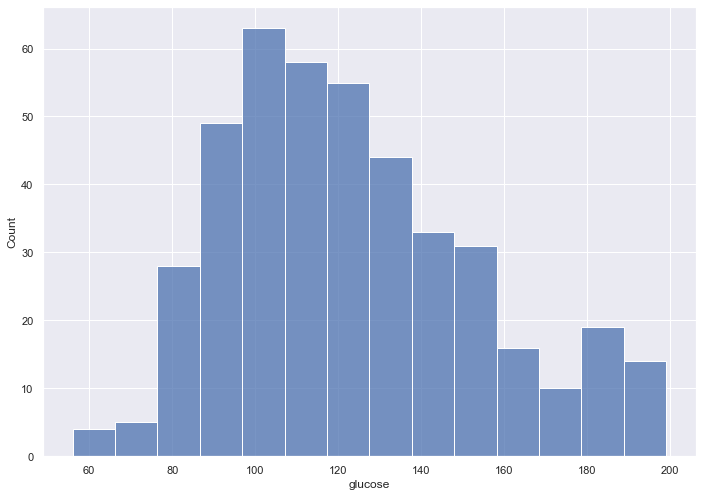

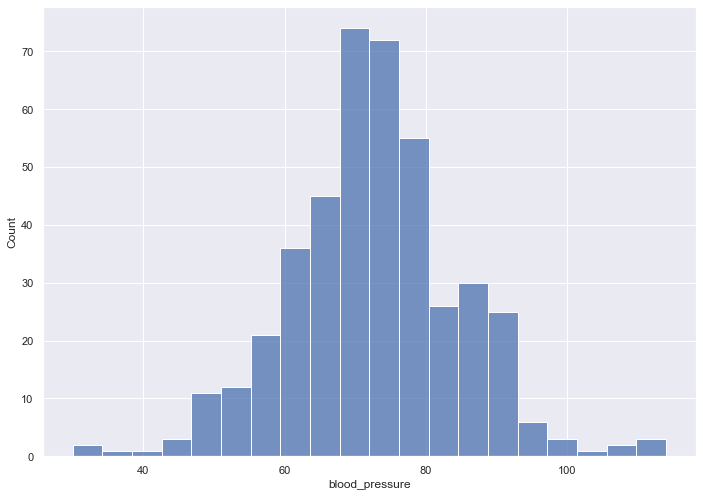

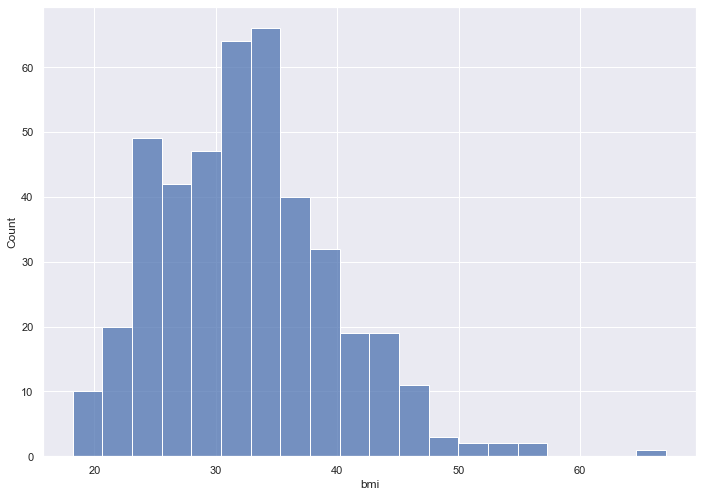

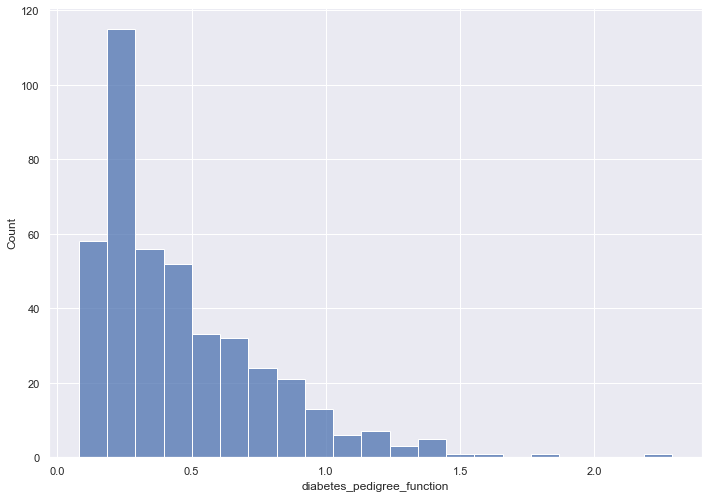

In [113]:
explore_nums(train, nums)

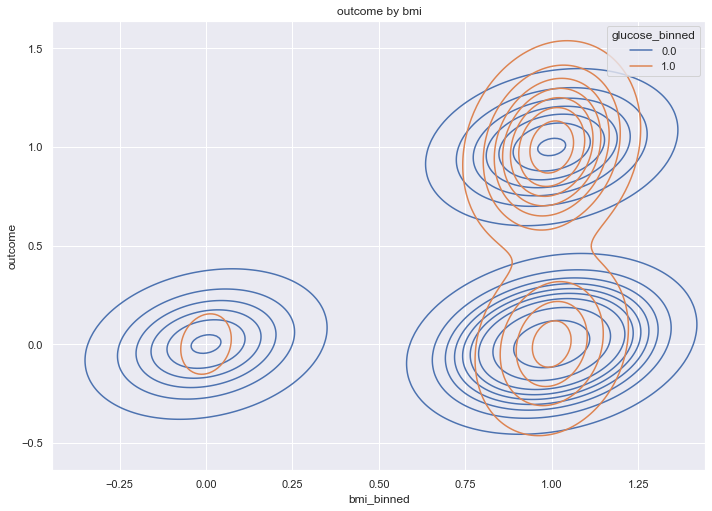

In [79]:
# looking closer at monthly charges and churn
sns.kdeplot(data=train, x='bmi_binned', y='outcome', hue='glucose_binned')
rate = train.outcome.mean()
plt.title('outcome by bmi')
plt.show()


# Pearsons R

In [114]:
test_results = stats.pearsonr(train.glucose, train.outcome)
test_results

(0.4872660149379471, 5.78701537406612e-27)

In [115]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0000000000


In [116]:
test_results = stats.pearsonr(train.blood_pressure, train.outcome)
test_results

(0.1605517307627027, 0.0008457510306723419)

In [117]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0008457510


In [118]:
test_results = stats.pearsonr(train.bmi, train.outcome)
test_results

(0.33256696485298226, 1.5450936832585465e-12)

In [119]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0000000000


In [120]:
test_results = stats.pearsonr(train.diabetes_pedigree_function, train.outcome)
test_results

(0.1638402412694729, 0.0006576360726489654)

In [121]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0006576361


In [ ]:
nums = ['glucose','blood_pressure','bmi','diabetes_pedigree_function']

# One Sample T-Test

In [124]:
pregnancies_bmi = train[train.pregnancies == 1].bmi
overall_bmi_mean = train.bmi.mean()

test_results = stats.ttest_1samp(pregnancies_bmi, overall_bmi_mean)
test_results



Ttest_1sampResult(statistic=-0.4709953258621794, pvalue=0.6390679905583102)

In [127]:
pregnancies_glucose = train[train.pregnancies == 1].glucose
overall_glucose_mean = train.glucose.mean()

test_results = stats.ttest_1samp(pregnancies_glucose, overall_glucose_mean)
test_results

Ttest_1sampResult(statistic=-2.311643064023405, pvalue=0.02366207579003089)

In [128]:
pregnancies_blood_pressure = train[train.pregnancies == 1].blood_pressure
overall_blood_pressure_mean = train.blood_pressure.mean()

test_results = stats.ttest_1samp(pregnancies_blood_pressure, overall_blood_pressure_mean)
test_results

Ttest_1sampResult(statistic=-3.2571748301651087, pvalue=0.0017177754810566632)

In [129]:
pregnancies_diabetes_pedigree_function = train[train.pregnancies == 1].diabetes_pedigree_function
overall_diabetes_pedigree_function_mean = train.diabetes_pedigree_function.mean()

test_results = stats.ttest_1samp(pregnancies_diabetes_pedigree_function, overall_diabetes_pedigree_function_mean)
test_results

Ttest_1sampResult(statistic=1.260876429724817, pvalue=0.2114238895862239)

In [132]:
age_bmi = train[train.age_binned == 1].bmi
overall_bmi_mean = train.bmi.mean()

test_results = stats.ttest_1samp(age_bmi, overall_bmi_mean)
test_results



Ttest_1sampResult(statistic=-2.0120001331106927, pvalue=0.04824347269120075)

In [127]:
age_glucose = train[train.age_binned == 1].glucose
overall_glucose_mean = train.glucose.mean()

test_results = stats.ttest_1samp(age_glucose, overall_glucose_mean)
test_results

Ttest_1sampResult(statistic=-2.311643064023405, pvalue=0.02366207579003089)

In [133]:
age_blood_pressure = train[train.age_binned == 1].blood_pressure
overall_blood_pressure_mean = train.blood_pressure.mean()

test_results = stats.ttest_1samp(age_blood_pressure, overall_blood_pressure_mean)
test_results

Ttest_1sampResult(statistic=5.293499056227054, pvalue=1.4289678654584301e-06)

In [129]:
age_diabetes_pedigree_function = train[train.age_binned == 1].diabetes_pedigree_function
overall_diabetes_pedigree_function_mean = train.diabetes_pedigree_function.mean()

test_results = stats.ttest_1samp(age_diabetes_pedigree_function, overall_diabetes_pedigree_function_mean)
test_results

Ttest_1sampResult(statistic=1.260876429724817, pvalue=0.2114238895862239)

In [80]:
# isolate or target variable and explore on train, 
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['outcome'])
y_train = train.outcome

X_validate = validate.drop(columns=['outcome'])
y_validate = validate.outcome

X_test = test.drop(columns=['outcome'])
y_test = test.outcome


In [83]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and pregnancies."
alternative_hypothesis = "There is a relationship between outcome and pregnancies."

# Setup a crosstab 
observed = pd.crosstab(train.outcome, train.pregnancies)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and pregnancies.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and pregnancies.
[[40.97202797 47.47552448 40.97202797 26.01398601 23.41258741 22.11188811
  15.60839161 16.25874126 12.35664336 11.70629371  9.75524476  3.25174825
   2.6013986   4.55244755  0.65034965  0.65034965  0.65034965]
 [22.02797203 25.52447552 22.02797203 13.98601399 12.58741259 11.88811189
   8.39160839  8.74125874  6.64335664  6.29370629  5.24475524  1.74825175
   1.3986014   2.44755245  0.34965035  0.34965035  0.34965035]]
pregnancies  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
outcome                                                                       
0            40  55  52  26  20  23  20  14   7   6   8   2   3   3   0   0   
1            23  18  11  14  16  11   4  11  12  12   7   3   1   4   1   1   

pregnancies  17  
outcome          
0             0  


In [84]:
'diabetes_pedigree_function', 'pregnancies_binned', 'age_binned', 'bp_binned', 'bmi_binned', 'glucose_binned'

('diabetes_pedigree_function',
 'pregnancies_binned',
 'age_binned',
 'bp_binned',
 'bmi_binned',
 'glucose_binned')

In [85]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and age."
alternative_hypothesis = "There is a relationship between outcome and age."

# Setup a crosstab of 
observed = pd.crosstab(train.outcome, train.age)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and age.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and age.
[[22.76223776 29.26573427 11.05594406 16.90909091 16.90909091 12.35664336
  11.70629371 15.60839161 11.05594406  7.15384615  7.8041958   5.85314685
   6.5034965   4.55244755  1.95104895  5.85314685  6.5034965   3.9020979
   5.85314685  3.25174825  9.75524476  5.2027972   6.5034965   1.3006993
   5.2027972   3.25174825  1.95104895  1.95104895  2.6013986   0.65034965
   2.6013986   2.6013986   2.6013986   1.95104895  1.3006993   1.3006993
   1.95104895  2.6013986   1.3006993   3.25174825  1.3006993   0.65034965
   2.6013986   1.95104895  1.3006993   1.3006993   1.3006993   0.65034965
   0.65034965  0.65034965]
 [12.23776224 15.73426573  5.94405594  9.09090909  9.09090909  6.64335664
   6.29370629  8.39160839  5.94405594  3.84615385  4.1958042   3.14685315
   3.4965035   2.44755245  1.04895105  3.14685

In [89]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and glucose_binned."
alternative_hypothesis = "There is a relationship between outcome and glucose_binned."

# Setup a crosstab 
observed = pd.crosstab(train.outcome, train.glucose_binned)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and glucose_binned.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and glucose_binned.
[[204.86013986  74.13986014]
 [110.13986014  39.86013986]]
glucose_binned  0.0  1.0
outcome                 
0               242   37
1                73   77
4.5351646741931836e-17


In [90]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and bmi_binned."
alternative_hypothesis = "There is a relationship between outcome and bmi_binned."

# Setup a crosstab 
observed = pd.crosstab(train.outcome, train.bmi_binned)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and bmi_binned.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and bmi_binned.
[[ 41.06775701 237.93224299]
 [ 21.93224299 127.06775701]]
bmi_binned  0.0  1.0
outcome             
0            59  220
1             4  145
5.9642087158192e-07


In [91]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and bp_binned."
alternative_hypothesis = "There is a relationship between outcome and bp_binned."

# Setup a crosstab 
observed = pd.crosstab(train.outcome, train.bp_binned)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and bp_binned.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and bp_binned.
[[216.56643357  62.43356643]
 [116.43356643  33.56643357]]
bp_binned  0.0  1.0
outcome            
0          229   50
1          104   46
0.0037433486118924005


In [92]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and age_binned."
alternative_hypothesis = "There is a relationship between outcome and age_binned."

# Setup a
observed = pd.crosstab(train.outcome, train.age_binned)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Fail to reject the null
Insufficient evidence to reject the null.
[[234.77622378  44.22377622]
 [126.22377622  23.77622378]]
age_binned  0.0  1.0
outcome             
0           239   40
1           122   28
0.301922921609258


In [93]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between outcome and pregnancies_binned."
alternative_hypothesis = "There is a relationship between outcome and  pregnancies_binned."

# Setup a crosstab 
observed = pd.crosstab(train.outcome, train.pregnancies_binned)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between outcome and pregnancies_binned.
Sufficient evidence to move forward understanding that. There is a relationship between outcome and  pregnancies_binned.
[[179.26401869  99.73598131]
 [ 95.73598131  53.26401869]]
pregnancies_binned  0.0  1.0
outcome                     
0                   193   86
1                    82   67
0.005073979422500659


In [134]:
X_train.head(25)

,pregnancies,glucose,blood_pressure,bmi,diabetes_pedigree_function,age,pregnancies_binned,glucose_binned,bp_binned,bmi_binned,age_binned
647,0,179.0,50.00,37.80,0.46,22,0.0,1.0,0.0,1.0,0.0
320,4,129.0,60.00,27.50,0.53,31,0.0,0.0,0.0,1.0,0.0
522,6,114.0,69.11,31.99,0.19,26,1.0,0.0,0.0,1.0,0.0
453,2,119.0,69.11,19.60,0.83,72,0.0,0.0,0.0,0.0,1.0
17,7,107.0,74.00,29.60,0.25,31,1.0,0.0,0.0,1.0,0.0
60,2,84.0,69.11,31.99,0.30,21,0.0,0.0,0.0,1.0,0.0
287,1,119.0,86.00,45.60,0.81,29,0.0,0.0,1.0,1.0,0.0
275,2,100.0,70.00,40.50,0.68,25,0.0,0.0,0.0,1.0,0.0
587,6,103.0,66.00,24.30,0.25,29,1.0,0.0,0.0,0.0,0.0
245,9,184.0,85.00,30.00,1.21,49,1.0,1.0,1.0,1.0,1.0


# Decision Tree

In [135]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [136]:
# model.fit(X, y)
clf = clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)

# Modeling

In [81]:
baseline = y_train.mode()
baseline

0    0
Name: outcome, dtype: int64

In [82]:
baseline_accuracy = (y_train == 0).mean()
baseline_accuracy

0.6503496503496503